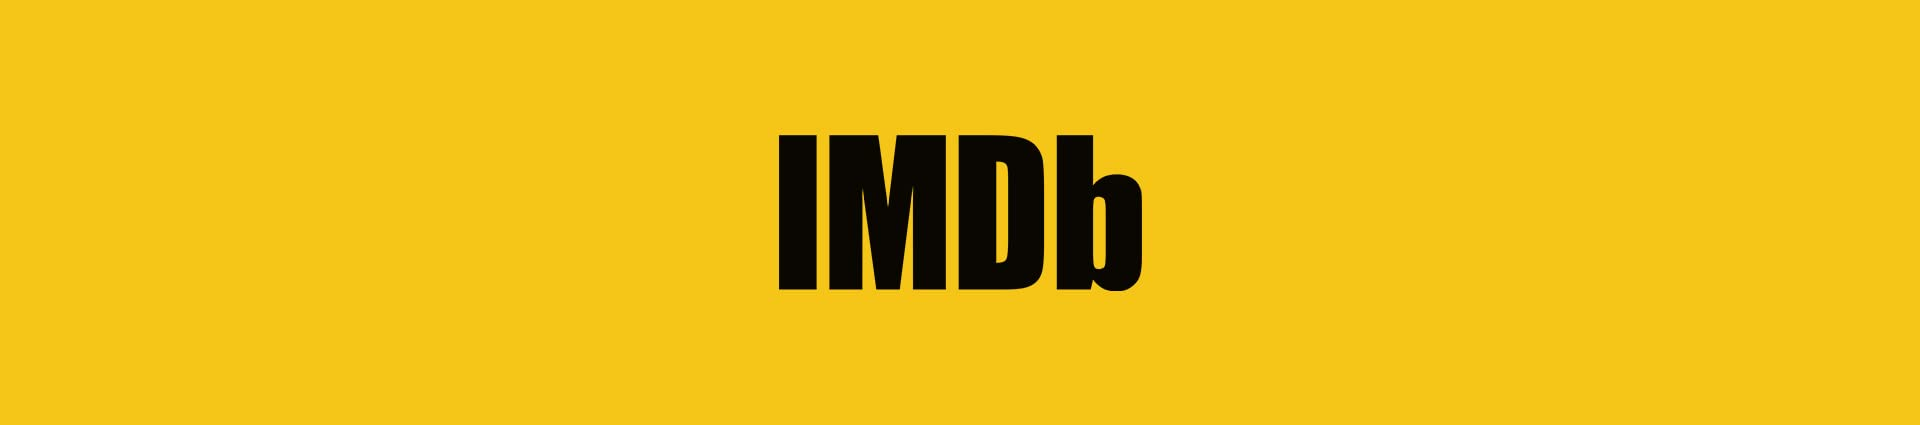

# Predicting IMDb Movie Rating using Multiclass Classification Models
---

CIS545 Final Project

Spring 2023

By Erica Wu, Aaron Wu, and Gary Adrian (Group 55)





# 1. Introduction
---
In this project, we are motivated to predict the IMDb rating of various movies by training several machine learning models (namely feedforward neural network (FNN), random forest, and logistic regression) with historical movie dataset (including features like genre, production companies, languages, budget, etc.). As the world's most popular online movie database, IMDb captures a critical metric of a movie's success by averaging ratings from the general public (not typically skewed towards big movie enthusiasts). As such, one can surmise that machine learning models capable of forecasting this metric can be beneficial for movie producers to predict how well their work will be perceived by the masses.

Datasets used for this project were sourced from the following:
- [Movies Daily Update Dataset](https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies) (by Akshay Pawar through Kaggle)
- [IMDb Movie Dataset: All Movies by Genre](https://https://www.kaggle.com/datasets/rajugc/imdb-movies-dataset-based-on-genre?select=thriller.csv) (by Chidambara Raju G through Kaggle)
- [Movies from TMDb](https://www.kaggle.com/datasets/stephanerappeneau/350-000-movies-from-themoviedborg?select=AllMoviesDetailsCleaned.csv) (by Stephanerappeneau through Kaggle)

The use of various datasets enables us to gather as many explanatory features as possible to build the most powerful models. While information representation from each dataset varies wildly, a movie ID (`tmdb_id` or `imdb_id`) presents as the common denominator to join across multiple datasets.

Since `imdb_rating` is a continuous data ranging from 0-10, we coded each movie datapoint as 1 out of 4 different `imdb_rating_class`:
- `imdb_rating`: 0.0 - 2.5 -> `imdb_rating_class` = 1
- `imdb_rating`: 2.5 - 5.0 -> `imdb_rating_class` = 2
- `imdb_rating`: 5.0 - 7.5 -> `imdb_rating_class` = 3
- `imdb_rating`: 7.5 - 10.0 -> `imdb_rating_class` = 4

The categorical nature of these rating bins allows us to focus our model building on multiclass classification (instead of regression).



# 2. Data Pre-Processing


---



## 2.0 Setup and Imports


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from google.colab import files

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import files
bmjo_df = pd.read_csv("/content/drive/Shareddrives/CIS545 Final Project Spring 2023/CSV Files/bmjo_movies.csv")
tmtf_df = pd.read_csv("/content/drive/Shareddrives/CIS545 Final Project Spring 2023/CSV Files/tmtf_movies.csv", sep=';')
imdb_df = pd.read_csv("/content/drive/Shareddrives/CIS545 Final Project Spring 2023/CSV Files/imdb_movies.csv")

## 2.1 View Imported Files

In [ ]:
bmjo_df

id                               title  \
0        76600            Avatar: The Way of Water   
1       631842                  Knock at the Cabin   
2       646389                               Plane   
3       505642      Black Panther: Wakanda Forever   
4       956101                   The Eighth Clause   
...        ...                                 ...   
722955  912452  Fallada - im Rausch des Schreibens   
722956  577763                        Kindly Scram   
722957  550579                         The Dancing   
722958  529345                          Dispatched   
722959  968161                       Gising Sining   

                                  genres original_language  \
0       Science Fiction-Adventure-Action                en   
1                Horror-Mystery-Thriller                en   
2              Action-Adventure-Thriller                en   
3       Action-Adventure-Science Fiction                en   
4                               Thriller                la   
...                                  ...               ...   
722955                       Documentary                de   
722956                         Animation                en   
722957                               NaN                fr   
722958                             Drama                en   
722959                               NaN                tl   

                                                 overview  popularity  \
0       Set more than a decade after the events of the...   10255.685   
1       While vacationing at a remote cabin a young gi...    3422.537   
2       After a heroic job of successfully landing his...    2618.646   
3       Queen Ramonda Shuri M’Baku Okoye and the Dora ...    2525.408   
4       Kat and Borja appear to be a perfect couple bu...    2259.303   
...                                                   ...         ...   
722955                                                NaN       0.600   
722956              A bill poster encounters a mean bull.       0.600   
722957                                                NaN       0.600   
722958  A paramedic named Al responds to an emergency ...       0.600   
722959  In a country where fascism foolishness of peop...       0.600   

                                     production_companies release_date  \
0           20th Century Studios-Lightstorm Entertainment   2022-12-14   
1       Blinding Edge Pictures-Universal Pictures-Film...   2023-02-01   
2       MadRiver Pictures-Di Bonaventura Pictures-G-BA...   2023-01-12   
3                                          Marvel Studios   2022-11-09   
4                            SDB Films-El Hombre Orquesta   2022-04-29   
...                                                   ...          ...   
722955                                                NaN   2016-11-23   
722956          Columbia Pictures Corporation-Screen Gems   1943-03-05   
722957                                                NaN   2014-10-05   
722958                                                NaN   2013-01-01   
722959                                          Studio RD          NaN   

             budget       revenue  runtime    status  \
0       460000000.0  2.309660e+09    192.0  Released   
1        20000000.0  5.200000e+07    100.0  Released   
2        25000000.0  5.100000e+07    107.0  Released   
3       250000000.0  8.585356e+08    162.0  Released   
4               0.0  0.000000e+00      0.0  Released   
...             ...           ...      ...       ...   
722955          0.0  0.000000e+00      0.0  Released   
722956          0.0  0.000000e+00      6.0  Released   
722957          0.0  0.000000e+00      NaN  Released   
722958          0.0  0.000000e+00     15.0  Released   
722959          0.0  0.000000e+00     19.0  Released   

                                                  tagline  vote_average  \
0                                      Return to Pandora.         7.739   
1       Save your family or s

In [ ]:
tmtf_df

id   budget                        genres    imdb_id  \
0            2        0                   Drama|Crime  tt0094675   
1            3        0                  Drama|Comedy  tt0092149   
2            5  4000000                  Crime|Comedy  tt0113101   
3            6        0         Action|Thriller|Crime  tt0107286   
4            8    42000                   Documentary  tt0825671   
...        ...      ...                           ...        ...   
329039  469215        0  Documentary|History|TV Movie  tt5430190   
329040  469216        0                           NaN        NaN   
329041  469217        0                  Drama|Comedy        NaN   
329042  469218        0                  Drama|Comedy  tt6391664   
329043  469219        0                         Drama  tt6413160   

       original_language                                original_title  \
0                     fi                                         Ariel   
1                     fi                          Varjoja paratiisissa   
2                     en                                    Four Rooms   
3                     en                                Judgment Night   
4                     en              Life in Loops (A Megacities RMX)   
...                  ...                                           ...   
329039                en                           The Day Hitler Died   
329040                de  Mobb Deep - Life of the Infamous: The Videos   
329041                en                                        #idiot   
329042                en                              Conspiracy P.I.E   
329043                en                                        Chance   

                                                 overview popularity  \
0       Taisto Kasurinen is a Finnish coal miner whose...   0.823904   
1       An episode in the life of Nikander, a garbage ...    0.47445   
2       It's Ted the Bellhop's first night on the job....      1.698   
3       While racing to a boxing match, Frank, Mike, J...    1.32287   
4       Timo Novotny labels his new project an experim...   0.054716   
...                                                   ...        ...   
329039  The story of Hitler’s final hours told by peop...     0.0045   
329040                                                NaN    0.00045   
329041  In the modern day pursuit of fame and fortune,...    1.37217   
329042  Director Levi A. Taylor invites you on a nosta...     0.0096   
329043  A homeless man is given a second chance at lif...     0.0759   

               production_companies      production_countries  ... runtime  \
0       Villealfa Filmproduction Oy                   Finland  ...    69.0   
1       Villealfa Filmproduction Oy                   Finland  ...    76.0   
2                     Miramax Films  United States of America  ...    98.0   
3                Universal Pictures                     Japan  ...   110.0   
4                           inLoops                   Austria  ...    80.0   
...                             ...                       ...  ...     ...   
329039              History Channel  United States of America  ...    46.0   
329040     Sony Music Entertainmant  United States of America  ...     NaN   
329041                         none                  Malaysia  ...    11.0   
329042                         none  United States of America  ...    12.0   
329043                         none  United States of America  ...    90.0   

        spoken_languages    status  \
0                  suomi  Released   
1                English  Released   
2                English  Released   
3                English  Released   
4                English  Released   
...                  ...       ...   
329039           Deutsch  Released   
329040           English  Released   
329041           English  Released   
329042           English  Released   
329043           English  Released   

                                               

In [ ]:
imdb_df

Unnamed: 0    imdb_id                      movie_name  year  \
0            19475  tt0000009                      Miss Jerry  1894   
1             9264  tt0000574     The Story of the Kelly Gang  1906   
2            10898  tt0000679  The Fairylogue and Radio-Plays  1908   
3             8332  tt0001049                  Gøngehøvdingen  1909   
4            33309  tt0001115                   Ansigttyven I  1910   
...            ...        ...                             ...   ...   
243518       31990  tt9916188                        Minotaur     I   
243519        9871  tt9916190                       Safeguard  2020   
243520       13558  tt9916270        Il talento del calabrone  2020   
243521         543  tt9916362                           Coven  2020   
243522       12086  tt9916428             The Secret of China  2019   

       certificate runtime                         genre  imdb_rating  \
0              NaN      45                       Romance          5.3   
1        Not Rated      70  Action, Adventure, Biography          6.0   
2              NaN     120            Fantasy, Adventure          5.2   
3              NaN     NaN                    Drama, War          3.5   
4              NaN     NaN                         Crime          4.6   
...            ...     ...                           ...          ...   
243518         NaN     NaN                      Thriller          NaN   
243519         NaN      95   Action, Adventure, Thriller          3.7   
243520         NaN      84                      Thriller          5.8   
243521       TV-MA      92                Drama, History          6.4   
243522         NaN     NaN       Adventure, History, War          3.8   

                                              description  \
0       The adventures of a female reporter in the 1890s.   
1       Story of Ned Kelly, an infamous 19th-century A...   
2       L. Frank Baum would appear in a white suit and...   
3                                              Add a Plot   
4       Consul Bjørn is urgently called to a company m...   
...                                                   ...   
243518  Plot unknown. Described as a supernatural thri...   
243519  When a Japanese restaurant is extorted by the ...   
243520  Dj Steph is a young radio deejay on the rise, ...   
243521  Basque Country, 1609. The men of the region ar...   
243522  Based on historical events, "Red China" tells ...   

                          director  \
0                  Alexander Black   
1                     Charles Tait   
2       Francis Boggs, Otis Turner   
3                     Carl Alstrup   
4               Gunnar Helsengreen   
...                            ...   
243518              Dean Israelite   
243519             Fraser Precious   
243520              Giacomo Cimini   
243521                Pablo Agüero   
243522                 Jixing Wang   

                                                     star  imdb_votes  gross  
0       Blanche Bayliss, William Courtenay, Chauncey D...       204.0    NaN  
1       Elizabeth Tait, John Tait, Nicholas Brierley, ...       810.0    NaN  
2       L. Frank Baum, Frank Burns, George E. Wilson, ...        67.0    NaN  
3       Aage Brandt, N. Eiberg, Solborg Fjeldsøe Rasmu...        17.0    NaN  
4       Philip Bech, Aage Bjørnbak, Alfred Cohn, Aage ...        20.0    NaN  
...                                                   ...         ...    ...  
243518                                                NaN         NaN    NaN  
243519  Patrick Gallagher, Sean Cronin, Lee Byford, Ta...       241.0    NaN  
243520  Sergio Castellitto, Lorenzo Richelmy, Anna Fog...      1394.0    NaN  
243521  Amaia Aberasturi, Alex Brendemühl, Daniel Fane...      5182.0    NaN  
243522  Kenan Heppe, Wang Peng Kai, Valery Gadreau, We...        14.0    NaN  

[243523 rows x 13 columns]

## 2.2 Joining TMDb datasets

We'll join our two TMDB datasets together based on TMDB_id, and fill
in missing data in the columns common to both datasets.

In [ ]:
# join the two tmdb databases together based on tmdb id
tmdb_df = bmjo_df.merge(tmtf_df, left_on = "id", right_on = "id", how = "right")

In [ ]:
# drop unnecessary columns
tmdb_df = tmdb_df.drop(columns = ['poster_path', 'backdrop_path',
                           'status_x', 'status_y', 'original_title',
                           'recommendations'])

In [ ]:
# fill in missing values from the right dataframe using values present in the left dataframe
fill_naive = ['title', 'original_language',
             'overview','production_companies',
             'release_date', 'tagline'] # columns to fill using naive method

fill_zeros = ['budget', 'revenue', 'runtime',
             'vote_average', 'vote_count'] # columns to fill in with > 0 vals if possible

In [ ]:
for col in fill_naive:
    tmdb_df[col] = np.where(tmdb_df[col + '_y'].isnull(), tmdb_df[col + '_x'], tmdb_df[col + '_y'])

for col in fill_zeros:
    tmdb_df[col] = np.where(tmdb_df[col + '_y'] == 0, tmdb_df[col + '_x'], tmdb_df[col + '_y'])

In [ ]:
tmdb_df_combined = tmdb_df.drop(columns = ['title_x',
        'original_language_x', 'overview_x',
       'popularity_x', 'production_companies_x', 'release_date_x', 'budget_x',
       'revenue_x', 'runtime_x', 'tagline_x', 'vote_average_x', 'vote_count_x',
       'budget_y',
       'original_language_y', 'overview_y', 'popularity_y',
       'production_companies_y', 'release_date_y',
       'revenue_y', 'runtime_y', 'tagline_y', 'title_y',
       'vote_average_y', 'vote_count_y'])

## 2.3 Joining with IMDb data

Similar process to 2.2, filling in missing data using a similar method.

In [ ]:
movies_df = tmdb_df_combined.merge(imdb_df, left_on = 'imdb_id', right_on = 'imdb_id')

In [ ]:
# fill in cols with other cols, as in the step joining tmdb data
movies_df = tmdb_df_combined.merge(imdb_df, left_on = 'imdb_id', right_on = 'imdb_id')
col='runtime'
movies_df[col] = np.where(movies_df[col + '_y']==0, movies_df[col + '_x'], movies_df[col + '_y'])
movies_df['revenue'] = np.where(movies_df['revenue']==0, movies_df['gross'], movies_df['revenue'])
movies_df['revenue'] = movies_df['revenue'].fillna(0)
movies_df['overview'] = movies_df['overview'].fillna(movies_df['description'])
# taking top 5 credits to fill in stars
movies_df['credits'] = movies_df['credits'].apply(
    lambda x: (", ".join(x.split("-")[:5])) if (isinstance(x, str)) else np.NaN)
movies_df['star'] = movies_df['star'].fillna(movies_df['credits'])

In [ ]:
# dropping cols
# drop meaningless cols like index
# drop cols used to fill in others
# drop genres because imdb genre is better
# drop year because there's release_date
movies_df = movies_df.drop(columns = ['runtime_x','runtime_y',
                                      'gross','Unnamed: 0',
                                      'movie_name', 'description',
                                      'credits', 'genres_x', 'genres_y', 'year'])

In [ ]:
# take out cols with lots of nulls and try dropna again
movies_df_curated = movies_df.drop(columns=['keywords','tagline','certificate'])
movies_df_curated = movies_df_curated.dropna()
movies_df_curated.shape

(75479, 22)

In [ ]:
# reorder columns
movies_df_curated = movies_df_curated[['id', 'imdb_id', 'title', 'overview',
                                      'release_date','runtime','genre',
                                      'production_countries','spoken_languages',
                                      'original_language','production_companies',
                                      'production_companies_number','production_countries_number',
                                      'director','star',
                                      'budget','revenue','vote_count','imdb_votes',
                                      'vote_average','imdb_rating']]

## 2.4 One-Hot Encoding
(and other columns derived from raw columns)

In [ ]:
# one hot encoding genre and language
one_hot = movies_df_curated.genre.str.get_dummies(', ')
movies_df_onehot_genre = movies_df_curated.drop(columns='genre')
movies_df_onehot_genre = movies_df_onehot_genre.join(one_hot)
movies_df_onehot = pd.get_dummies(movies_df_onehot_genre, columns=['original_language'])

In [ ]:
# get some more fields
movies_df_onehot['title_charcount'] = movies_df_onehot['title'].apply(lambda x: len(x))
movies_df_onehot['overview_wordcount'] = movies_df_onehot['overview'].apply(lambda x: x.count(" ")+1)

In [ ]:
# dealing with dates
movies_df_onehot['release_date'] = pd.to_datetime(movies_df_onehot['release_date'], dayfirst=True)
movies_df_onehot['year'] = movies_df_onehot['release_date'].apply(lambda x: x.year)
movies_df_onehot['month'] =movies_df_onehot['release_date'].apply(lambda x: x.month)

In [ ]:
# view final dataframe
movies_df_onehot

id    imdb_id                title  \
0           2  tt0094675                Ariel   
1           3  tt0092149  Shadows in Paradise   
2           6  tt0107286       Judgment Night   
3          11  tt0076759            Star Wars   
4          12  tt0266543         Finding Nemo   
...       ...        ...                  ...   
92965  469206  tt0435668              The Inn   
92966  469208  tt5640126           Transhuman   
92967  469208  tt5640126           Transhuman   
92968  469209  tt6258256  Six Feet Below Hell   
92969  469211  tt6451666             Cocolors   

                                                overview release_date runtime  \
0      Taisto Kasurinen is a Finnish coal miner whose...   1988-10-21      72   
1      An episode in the life of Nikander, a garbage ...   1986-10-16      74   
2      While racing to a boxing match, Frank, Mike, J...   1993-10-15     110   
3      Princess Leia is captured and held hostage by ...   1977-05-25     121   
4      Nemo, an adventurous young clownfish, is unexp...   2003-05-30     100   
...                                                  ...          ...     ...   
92965  A television reporter investigates a small tow...   2004-11-06    96.0   
92966  After a dangerous trip to Africa, investigativ...   2017-07-11      88   
92967  After a dangerous trip to Africa, investigativ...   2017-07-11      88   
92968  After a terrorist attack unleashes a virus tha...   2017-06-20     133   
92969  Aki isn’t a brave little boy, but he’s dedicat...   2017-02-07      45   

           production_countries spoken_languages         production_companies  \
0                       Finland            suomi  Villealfa Filmproduction Oy   
1                       Finland          English  Villealfa Filmproduction Oy   
2                         Japan          English           Universal Pictures   
3      United States of America          English                    Lucasfilm   
4      United States of America          English      Pixar Animation Studios   
...                         ...              ...                          ...   
92965                      none             none                         none   
92966                      none             none                         none   
92967                      none             none                         none   
92968                      none             none                         none   
92969                     Japan              日本語               Kamikaze Douga   

       production_companies_number  ...  original_language_uk  \
0                                2  ...                     0   
1                                1  ...                     0   
2                                3  ...                     0   
3                                2  ...                     0   
4                                1  ...                     0   
...                            ...  ...                   ...   
92965                            0  ...                     0   
92966                            0  ...                     0   
92967                            0  ...                     0   
92968                            0  ...                     0   
92969                            1  ...                     0   

      original_language_ur original_language_uz  original_language_vi  \
0                        0                    0                     0   
1                        0                    0                     0   
2                        0                    0                     0   
3                        0                    0                     0   
4                        0                    0                     0   
...                    ...                  ...                   ...   
92965                    0                    0                     0   
92966                    0                    0                     0   
92967                    0            

In [ ]:
# get the cleaned csv file obtained in 1.4 from drive
movies_cleaned_and_joined = pd.read_csv("/content/drive/Shareddrives/CIS545 Final Project Spring 2023/CSV Files/movies_cleaned_and_joined.csv")

## 2.5 Modified One Hot Encoding

### 2.5.1 Reverse and new One-hot on Original Language
---
Since we decided to reformat the one hot for `original_language`, we needed to first reverse one-hot the `original_langauge` column and then one hot encode the new column.

In [ ]:
# remove spoken_language since we decided this will not be used
movies_og_lang_df = movies_cleaned_and_joined.drop(columns='spoken_languages', axis=1)

# limit the new dataframe to only have countries that are identified
movies_og_lang_df = movies_og_lang_df.query('production_countries != "none"')

# reverse one-hot
movies_reserve = movies_og_lang_df.iloc[:, 43:133]
movies_og_lang_df = movies_og_lang_df.drop(movies_og_lang_df.iloc[:, 43:133], axis=1)
substring = "original_language_"
movies_og_lang_df['original_language'] = movies_reserve.apply(lambda x: x.eq(1).idxmax().replace(substring, ""), axis=1)

# Get top 10 languages from movie count, for languages not in to 10, assign dummy
count_list = movies_og_lang_df.original_language.value_counts().head(10)
top_ten = movies_og_lang_df.original_language.value_counts().nlargest(10)
movies_og_lang_df['top_ten_languages'] = movies_og_lang_df.original_language.apply(lambda x: x if x in top_ten else "dummy")

# one hot encode top languages
movies_og_lang_df = pd.get_dummies(movies_og_lang_df, columns=['top_ten_languages'])

### 2.5.2 Director Ranking
---
We now want to get the ranking of directors by the number of movies they directed. Since some of the movies are co-directed by my multiple directors, we first explode the list of directors and get the the ranking of directors individually. Afterwards, for each movie that are co-directed, we take the director that has the most count to represent that movie.

In [ ]:
# Helper function to get the top directors
# not top = 0, top 100 = 1, top 50 = 2, top 10 = 3
def define_director_rank(director):
    if director in top_hundred_count:
        return 1
    elif director in top_fifty_count:
        return 2
    elif director in top_ten_count:
        return 3
    else:
        return 0

In [ ]:
# get the list of columns not needed for merging director counts
drop_list = movies_og_lang_df.columns.tolist()
drop_list.remove('id')
drop_list.remove('imdb_rating')
drop_list.remove('vote_average')
drop_list.remove('director')

# get a dataframe with directors exploded
final_explode = movies_og_lang_df
explode_directors = final_explode.drop(columns=drop_list, axis=1)
explode_directors.director = explode_directors.director.str.split(", ")
explode_directors = explode_directors.explode('director')

# get a final dataframe with directors exploded for merging
final_explode.director = final_explode.director.str.split(", ")
final_explode = final_explode.explode('director')

In [ ]:
# get director ranking by counts
temp_director_count_df = explode_directors.groupby('director').count().reset_index('director')

rank_count_df = pd.DataFrame()
rank_count_df['director'] = temp_director_count_df.director
rank_count_df['count'] = temp_director_count_df.id
rank_count_df = rank_count_df.sort_values(by='count', ascending=False);

# store the rankings inside a list
top_ten_count = rank_count_df.director.head(10).tolist()
top_fifty_count = (rank_count_df.iloc[10:]).director.head(40).tolist()
top_hundred_count = (rank_count_df.iloc[50:]).director.head(50).tolist()

In [ ]:
# sort by count on the exploded df for merging
final_explode['director_ranking'] = final_explode.director.apply(lambda x: define_director_rank(x))
final_explode = final_explode.sort_values(by='director_ranking', ascending=False)
temp_count_ranking_df = final_explode[['id', 'director_ranking']].drop_duplicates()

# get a copy of original dataframe and rename vote_average, vote_counts
final_director_added = movies_og_lang_df
final_director_added = final_director_added.rename(columns={'vote_average': 'tmdb_rating', 'vote_count': 'tmdb_votes'})

# merge back the result to get the ranking of directors
final_director_added = (final_director_added.merge(temp_count_ranking_df, on='id')).drop_duplicates(subset=['id', 'title'])

# one hot encode rankings
director_added = pd.get_dummies(final_director_added, columns=['director_ranking'])

### 2.5.3 Country Ranking
---
We now do the same thing to get the ranking of countries by the number of movies produced in that country. Since there are less unique countries, we break down the category by top 50, 25, and 10.

In [ ]:
# Helper function to get the top countries
# not top = 0, top 50 = 1, top 25 = 2, top 10 = 3
def define_country_rank(country):
    if country in top_fifty_countries_list:
        return 1
    elif country in top_twenty_five_countries_list:
        return 2
    elif country in top_ten_countries_list:
        return 3
    else:
        return 0

In [ ]:
# create a copy of direction_added for final encoding
country_added = director_added

# get countries by count
filter_count_df = country_added.groupby('production_countries').count().reset_index('production_countries')
count_df = filter_count_df[['production_countries', 'id']]
filter_count_df = filter_count_df[['production_countries', 'id']]
count_df = count_df.sort_values(by='id', ascending=False)

# get top list
top_ten_countries_list = count_df.production_countries.head(10).tolist()
top_twenty_five_countries_list = (count_df.iloc[10:]).production_countries.head(15).tolist()
top_fifty_countries_list = (count_df.iloc[25:]).production_countries.head(25).tolist()

# create a new column for production_country_ranking and one-hot encode it
country_added['production_country_ranking'] = country_added.production_countries.apply(lambda x: define_country_rank(x))
country_added = pd.get_dummies(country_added, columns=['production_country_ranking'])

### 2.5.4 Company Ranking
We now want to get the ranking of production companies by the number of movies produced by that production company. The step follows what we did for directors, in which we have to first explode the list of production companies to get the top ranking company and set that as the determining movie production company.

In [ ]:
# Helper function to get the top countries
# not top = 0, top 100 = 1, top 50 = 2, top 10 = 3
def define_company_rank(company):
    if company in top_hundred_comp_list:
        return 1
    elif company in top_fifty_comp_list:
        return 2
    elif company in top_ten_comp_list:
        return 3
    else:
        return 0

In [ ]:
# make a copy of country_added for company ranking
company_added = country_added

# explode company list
exploded_movies_df = company_added[['id', 'tmdb_rating', 'imdb_rating', 'production_companies']]
exploded_movies_df = exploded_movies_df.explode(column='production_companies')

# filter companies with less than 5 movies produced
filter_count_company_df = exploded_movies_df.groupby('production_companies').count().reset_index('production_companies')
filter_count_company_df = filter_count_company_df.drop(columns=['tmdb_rating', 'imdb_rating'])
count_df = filter_count_company_df.sort_values(by='id', ascending=False)

# get top list count
top_ten_comp_list = count_df.production_companies.head(10).tolist()
top_fifty_comp_list = (count_df.iloc[10:]).production_companies.head(40).tolist()
top_hundred_comp_list = (count_df.iloc[50:]).production_companies.head(50).tolist()

# count ranking
merge_imdb = exploded_movies_df
merge_imdb['production_company_ranking'] = merge_imdb.production_companies.apply(lambda x: define_company_rank(x))
merge_imdb = merge_imdb.sort_values(by='production_company_ranking', ascending=False)
merge_imdb = merge_imdb[['id', 'production_company_ranking']]
merge_imdb = merge_imdb.drop_duplicates(subset=['id'])
company_added = company_added.merge(merge_imdb, on='id')

# one hot
company_added = pd.get_dummies(company_added, columns=['production_company_ranking'])

### 2.5.5 Star Ranking
Do the same procedure for the `star` column of the data

In [ ]:
# Helper function to get the top star
# not top = 0, top 100 = 1, top 50 = 2, top 10 = 3
def define_count_star_rank(star):
    if star in top_hundred_count:
        return 1
    elif star in top_fifty_count:
        return 2
    elif star in top_ten_count:
        return 3
    else:
        return 0

In [ ]:
# make a copy of company_added to one-hot encode star
star_added = company_added

#explode stars into single star
drop_list = star_added.columns.tolist()
final_explode = star_added
drop_list.remove('id')
drop_list.remove('imdb_rating')
drop_list.remove('star')
explode_star = star_added.drop(columns=drop_list, axis=1)
explode_star.star = explode_star.star.str.split(", ")
explode_star = explode_star.explode('star')

# get an exploded version of final dataframe for merging
final_explode = star_added
final_explode.star = final_explode.star.str.split(", ")
final_explode = final_explode.explode('star')

In [ ]:
# get the result of the top star
temp_count_df = explode_star.groupby('star').count().reset_index('star')

rank_count_df = pd.DataFrame()
rank_count_df['star'] = temp_count_df.star
rank_count_df['count'] = temp_count_df.id
rank_count_df = rank_count_df.sort_values(by='count', ascending=False);

# store the result into lists
top_ten_count = rank_count_df.star.head(10).tolist()
top_fifty_count = (rank_count_df.iloc[10:]).star.head(40).tolist()
top_hundred_count = (rank_count_df.iloc[50:]).star.head(50).tolist()

In [ ]:
# add result into exploded dataframe for merging
final_explode['star_ranking'] = final_explode.star.apply(lambda x: define_count_star_rank(x))
final_explode = final_explode.sort_values(by='star_ranking', ascending=False)
temp_count_ranking_df = final_explode[['id', 'star_ranking']].drop_duplicates()
star_added = (star_added.merge(temp_count_ranking_df, on='id')).drop_duplicates(subset=['id', 'title'])

# one hot encode rankings
star_added = pd.get_dummies(star_added, columns=['star_ranking'])

### 2.5.6 Extracting potentially useful informations
---
Before performing sentiment analysis, we want to first extract some other informations that could potentially be useful. Namely, we want to extract their word length and chararcter length from the columns `title` and `overview`. Then using the `year` and `month` column, we want to get the average rating for each `year` `month` combination.

In [ ]:
# create a copy of star_added to add the informations
extract_others = star_added

temp_df = extract_others[['id', 'title', 'overview']]

# getting relevant title info
temp_title_df = extract_others[['id', 'title']].copy(deep=True)
temp_title_df['title'] = temp_title_df.title.str.split()
extract_others['title_char_count'] = extract_others.title.apply(lambda x: len(x))
extract_others['title_word_count'] = temp_title_df.title.apply(lambda x: len(x))

In [ ]:
# getting relevant overview infos
temp_overview_df = extract_others[['id', 'overview']].copy(deep=True)
temp_overview_df['overview'] = temp_overview_df.overview.str.split()
extract_others['overview_char_count'] = extract_others.overview.apply(lambda x: len(x))
extract_others['overview_word_count'] = temp_overview_df.overview.apply(lambda x: len(x))

In [ ]:
# getting avg-rating by month & year
temp_avg_df = extract_others[['id', 'year', 'month']].copy(deep=True)
temp_avg_df['time_avg_rating'] = extract_others.imdb_rating
temp_avg_df = temp_avg_df.groupby(['year', 'month'])['time_avg_rating'].mean().reset_index(['year', 'month']).sort_values(by=['year', 'month'])
temp_avg_df.time_avg_rating = round(temp_avg_df.time_avg_rating, 3)
extract_others = extract_others.merge(temp_avg_df, on=['year', 'month'])

## 2.6 Sentiment Analysis
---
Perform Sentiment Analysis. Since we want the code to be more readable, we defined two helper functions.

In [ ]:
# set the defaults for punctuations and stopwords
punctuations = set(punctuation)
stop_words = set(stopwords.words('english'))

In [ ]:
# Helper function for tokenizing sentences
def clean_tokenize_lists(lists):
    cleaned_lists = []
    for lst in lists:
        tokens = nltk.word_tokenize(' '.join(lst))
        cleaned_tokens = [token.lower() for token in tokens if
                          token.lower() not in stop_words and token.lower() not in punctuations]
        cleaned_lists.append(cleaned_tokens)
    return cleaned_lists

# Helper function for performing sentiment analysis
def sentiment_analysis(lists):
    sentiment_scores = []
    for lst in lists:
        sentence = ' '.join(lst)
        sentiment = TextBlob(sentence).sentiment.polarity
        sentiment_scores.append(round(sentiment, 3))
    return sentiment_scores

In [ ]:
# create a copy of extract_others to save final result after performing
# sentiment analysis
movies_final_added = extract_others

# Tokenize and perform sentiment analysis
temp_df = movies_final_added[['id', 'overview']].copy(deep=True)
temp_df['tokenized_text'] = temp_df.overview.apply(lambda x: word_tokenize(x))
temp_df.tokenized_text = clean_tokenize_lists(temp_df.tokenized_text)
movies_final_added['sentiment_score'] = sentiment_analysis(temp_df.tokenized_text)

## 2.7 Imputing NaN Values in Budget

Since some movies have NaN values for their `budget`, we want to impute these values to get the feature to be more useful for our prediction. We first decide if we want to impute the values using the mean or median values by visualizing the non-NaN `budget` data.

In [ ]:
# get a statistics summary of datasets with non-NaN budget value
movies_final_added = movies_final_added.rename(columns={'id': 'tmdb_id'})
movies_final_added.describe()

Unnamed: 0        tmdb_id       runtime  production_companies_number  \
count  52456.000000   52456.000000  52456.000000                 52456.000000   
mean   40518.688787  172508.208460     97.991078                     1.471157   
std    27321.441081  142497.836258     23.748263                     1.523522   
min        0.000000       2.000000      1.000000                     0.000000   
25%    15129.750000   39978.500000     86.000000                     1.000000   
50%    39193.500000  138477.500000     94.000000                     1.000000   
75%    62908.250000  291900.250000    106.000000                     2.000000   
max    92969.000000  469211.000000    999.000000                    26.000000   

       production_countries_number        budget       revenue    tmdb_votes  \
count                 52456.000000  5.245600e+04  5.245600e+04  52456.000000   
mean                      1.196412  3.955157e+06  1.075439e+07     84.709986   
std                       0.556028  1.734685e+07  6.598672e+07    485.538237   
min                       1.000000  0.000000e+00  0.000000e+00      0.000000   
25%                       1.000000  0.000000e+00  0.000000e+00      1.000000   
50%                       1.000000  0.000000e+00  0.000000e+00      4.000000   
75%                       1.000000  0.000000e+00  0.000000e+00     16.000000   
max                      12.000000  4.600000e+08  2.799439e+09  26445.000000   

         imdb_votes   tmdb_rating  ...  star_ranking_0  star_ranking_1  \
count  5.245600e+04  52456.000000  ...    52456.000000    52456.000000   
mean   1.515321e+04      5.193404  ...        0.904244        0.038508   
std    7.438807e+04      2.170719  ...        0.294260        0.192422   
min    5.000000e+00      0.000000  ...        0.000000        0.000000   
25%    1.340000e+02      4.500000  ...        1.000000        0.000000   
50%    6.490000e+02      5.700000  ...        1.000000        0.000000   
75%    3.319000e+03      6.500000  ...        1.000000        0.000000   
max    2.675531e+06     10.000000  ...        1.000000        1.000000   

       star_ranking_2  star_ranking_3  title_char_count  title_word_count  \
count    52456.000000    52456.000000      52456.000000      52456.000000   
mean         0.042512        0.014736         16.148829          2.905978   
std          0.201756        0.120496          8.309889          1.601581   
min          0.000000        0.000000          1.000000          1.000000   
25%          0.000000        0.000000         10.000000          2.000000   
50%          0.000000        0.000000         15.000000          3.000000   
75%          0.000000        0.000000         20.000000          4.000000   
max          1.000000        1.000000        117.000000         20.000000   

       overview_char_count  overview_word_count  time_avg_rating  \
count         52456.000000         52456.000000     52456.000000   
mean            305.877078            52.674279         5.908392   
std             206.268236            35.535669         0.324791   
min               1.000000             0.000000         3.400000   
25%             145.000000            25.000000         5.660000   
50%             254.000000            44.000000         5.886000   
75%             415.000000            71.000000         6.135000   
max            1000.000000           188.000000         8.500000   

       sentiment_score  
count     52456.000000  
mean          0.033705  
std           0.223886  
min          -1.000000  
25%          -0.067000  
50%           0.006000  
75%           0.150000  
max           1.000000  

[8 rows x 72 columns]

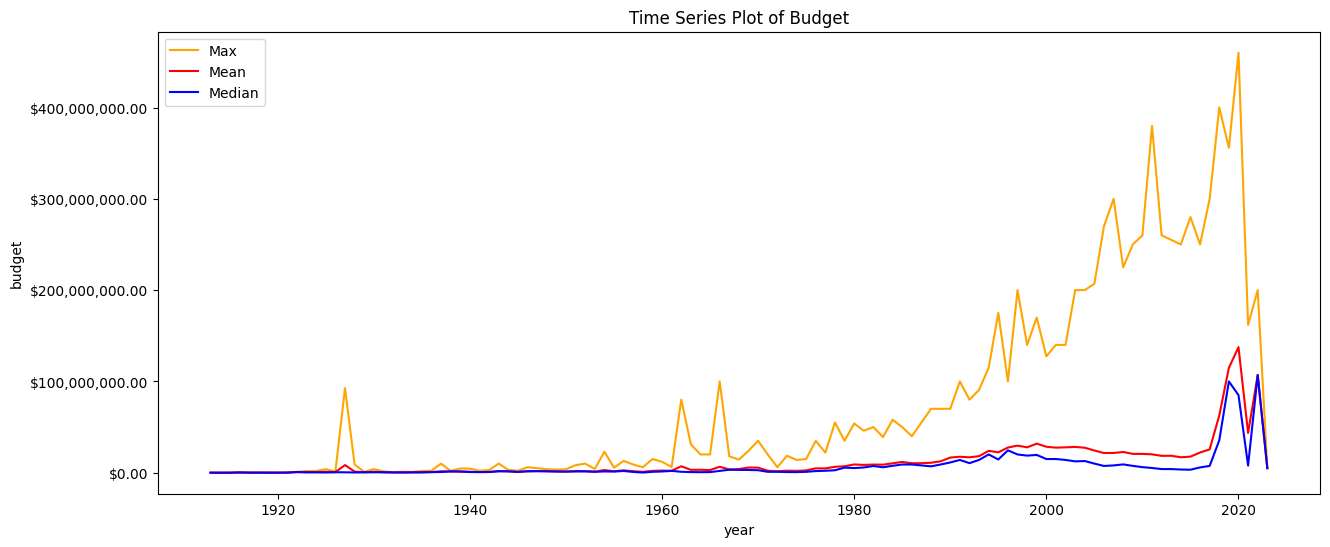

In [ ]:
# plot a time series max, mean, and median budget
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=movies_final_added[movies_final_added['budget'] != 0][['year', 'budget']].groupby(['year']).max().reset_index(),
             x='year',
             y='budget',
             color='orange',
             errorbar=None)
sns.lineplot(data=movies_final_added[movies_final_added['budget'] != 0][['year', 'budget']].groupby(['year']).mean().reset_index(),
             x='year',
             y='budget',
             color='red',
             errorbar=None)
sns.lineplot(data=movies_final_added[movies_final_added['budget'] != 0][['year', 'budget']].groupby(['year']).median().reset_index(),
             x='year',
             y='budget',
             color='blue',
             errorbar=None)
ax.set_title('Time Series Plot of Budget')
current_ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.2f}'.format(x) for x in current_ticks])
ax.legend(['Max', 'Mean','Median'])
plt.show()

Looking at these time series plots, some of the `budget` max values seem to be way above the mean and median. Given this, we decided to be conservative with imputing NaN values and use median value (instead of the mean) to impute NaN values of each year.

In [ ]:
# compute imputed budget values for each year
imputed_budget_df = movies_final_added[movies_final_added['budget'] != 0][['year', 'budget']].groupby(['year']).median().reset_index()
imputed_budget_df = imputed_budget_df.rename(columns={'budget': 'imputed_budget_value'})

In [ ]:
# join imputed budget values with the original movies_final_added
movies_final_df = movies_final_added.merge(imputed_budget_df,
                                           how='left',
                                           left_on='year',
                                           right_on='year')

In [ ]:
# flag imputed_budget = 1 if budget = 0
movies_final_df['imputed_budget_flag'] = movies_final_df['budget'].apply(lambda x: 1 if x == 0 else 0)

In [ ]:
# for any movie with budget = 0, replace NaN budget with the imputed_budget value
movies_final_df['real_budget'] = movies_final_df[['imputed_budget_value', 'budget']].max(axis=1)
imputed_budget_remaining = movies_final_df[movies_final_df['year'] == 1919][['real_budget']].median().item()
movies_final_df['real_budget'] = movies_final_df['real_budget'].apply(lambda x: imputed_budget_remaining if x == 0 else x)

In [ ]:
# revisit statistics summary of movies_final_df after imputing NaN budget
movies_final_df[['year', 'real_budget']].describe()

year   real_budget
count  52456.000000  5.245600e+04
mean    1987.106184  9.234730e+06
std       26.032905  1.727705e+07
min     1894.000000  2.640000e+02
25%     1968.000000  1.670000e+06
50%     1994.000000  5.575000e+06
75%     2010.000000  1.000000e+07
max     2023.000000  4.600000e+08

In [ ]:
# one last drop of all unnecessary columns
movies_final_df = movies_final_df.drop(columns=['tmdb_id', 'Unnamed: 0', 'revenue', 'title_charcount', 'overview_wordcount', 'imputed_budget_value', 'budget'])

In [ ]:
# one last renaming of some columns
movies_final_df = movies_final_df.rename(columns={'real_budget':'budget'})

In [ ]:
# add imdb_rating_class column
# 1: 0 <= imdb_rating < 2.5
# 2: 2.5 <= imdb_rating < 5
# 3: 5 <= imdb_rating < 7.5
# 4: 7.5 <= imdb_rating < 10
movies_final_df['imdb_rating_class'] = movies_final_df['imdb_rating'].apply(lambda x: 1 if x < 2.5 else
                                                                            2 if (x>=2.5) & (x<5) else
                                                                            3 if (x>=5) & (x<7.5) else
                                                                            4)

In [ ]:
movies_final_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52456 entries, 0 to 52455
Data columns (total 78 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   imdb_id                       52456 non-null  object 
 1   title                         52456 non-null  object 
 2   overview                      52456 non-null  object 
 3   release_date                  52456 non-null  object 
 4   runtime                       52456 non-null  float64
 5   production_countries          52456 non-null  object 
 6   production_companies          52456 non-null  object 
 7   production_companies_number   52456 non-null  int64  
 8   production_countries_number   52456 non-null  int64  
 9   director                      52456 non-null  object 
 10  star                          52456 non-null  object 
 11  tmdb_votes                    52456 non-null  float64
 12  imdb_votes                    52456 non-null  float64
 13  t

## 2.8 Export Final Dataframe

We have now derived the finalized (joined and cleaned) movie dataframe. This final dataframe is exported for each group member's reference so that our various model building workstreams can occur subsequently.

In [ ]:
# export movies_final_df for subsequent modelling
movies_final_df.to_csv("movies_final.csv", index=False)
#files.download('movies_final.csv')

## 2.9 Export Final IMDb Dataframes

From the above final dataframe, we can also derive the finalized dataframe specifically for classification. This dataframe only contains the features and label columns that can be fed into our models.

In [ ]:
# IMDb movies dataframe for model building
imdb_movies_final_df = movies_final_df.drop(columns=['imdb_id',
                                                     'title',
                                                     'overview',
                                                     'release_date',
                                                     'production_companies',
                                                     'production_countries',
                                                     'director',
                                                     'star',
                                                     'tmdb_votes',
                                                     'imdb_rating',
                                                     'tmdb_rating',
                                                     'year',
                                                     'month',
                                                     'original_language'])
imdb_movies_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52456 entries, 0 to 52455
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   runtime                       52456 non-null  float64
 1   production_companies_number   52456 non-null  int64  
 2   production_countries_number   52456 non-null  int64  
 3   imdb_votes                    52456 non-null  float64
 4   Action                        52456 non-null  int64  
 5   Adult                         52456 non-null  int64  
 6   Adventure                     52456 non-null  int64  
 7   Animation                     52456 non-null  int64  
 8   Biography                     52456 non-null  int64  
 9   Comedy                        52456 non-null  int64  
 10  Crime                         52456 non-null  int64  
 11  Drama                         52456 non-null  int64  
 12  Family                        52456 non-null  int64  
 13  F

In [ ]:
# export imdb_movies_final_df for subsequent modelling
imdb_movies_final_df.to_csv("imdb_movies_final.csv", index=False)
#files.download('imdb_movies_final.csv')

# 3. Exploratory Data Analysis (EDA)


---



## 3.1 Correlation Matrix
We begin our dataset investigation by constructing a correlation matrix of all our 62 features. The presence of any significant correlations may inform us about data redundancies, which subsequently suggests the need of dimensionality reduction (i.e. PCA) to capture just enough variance explaining our original variables.

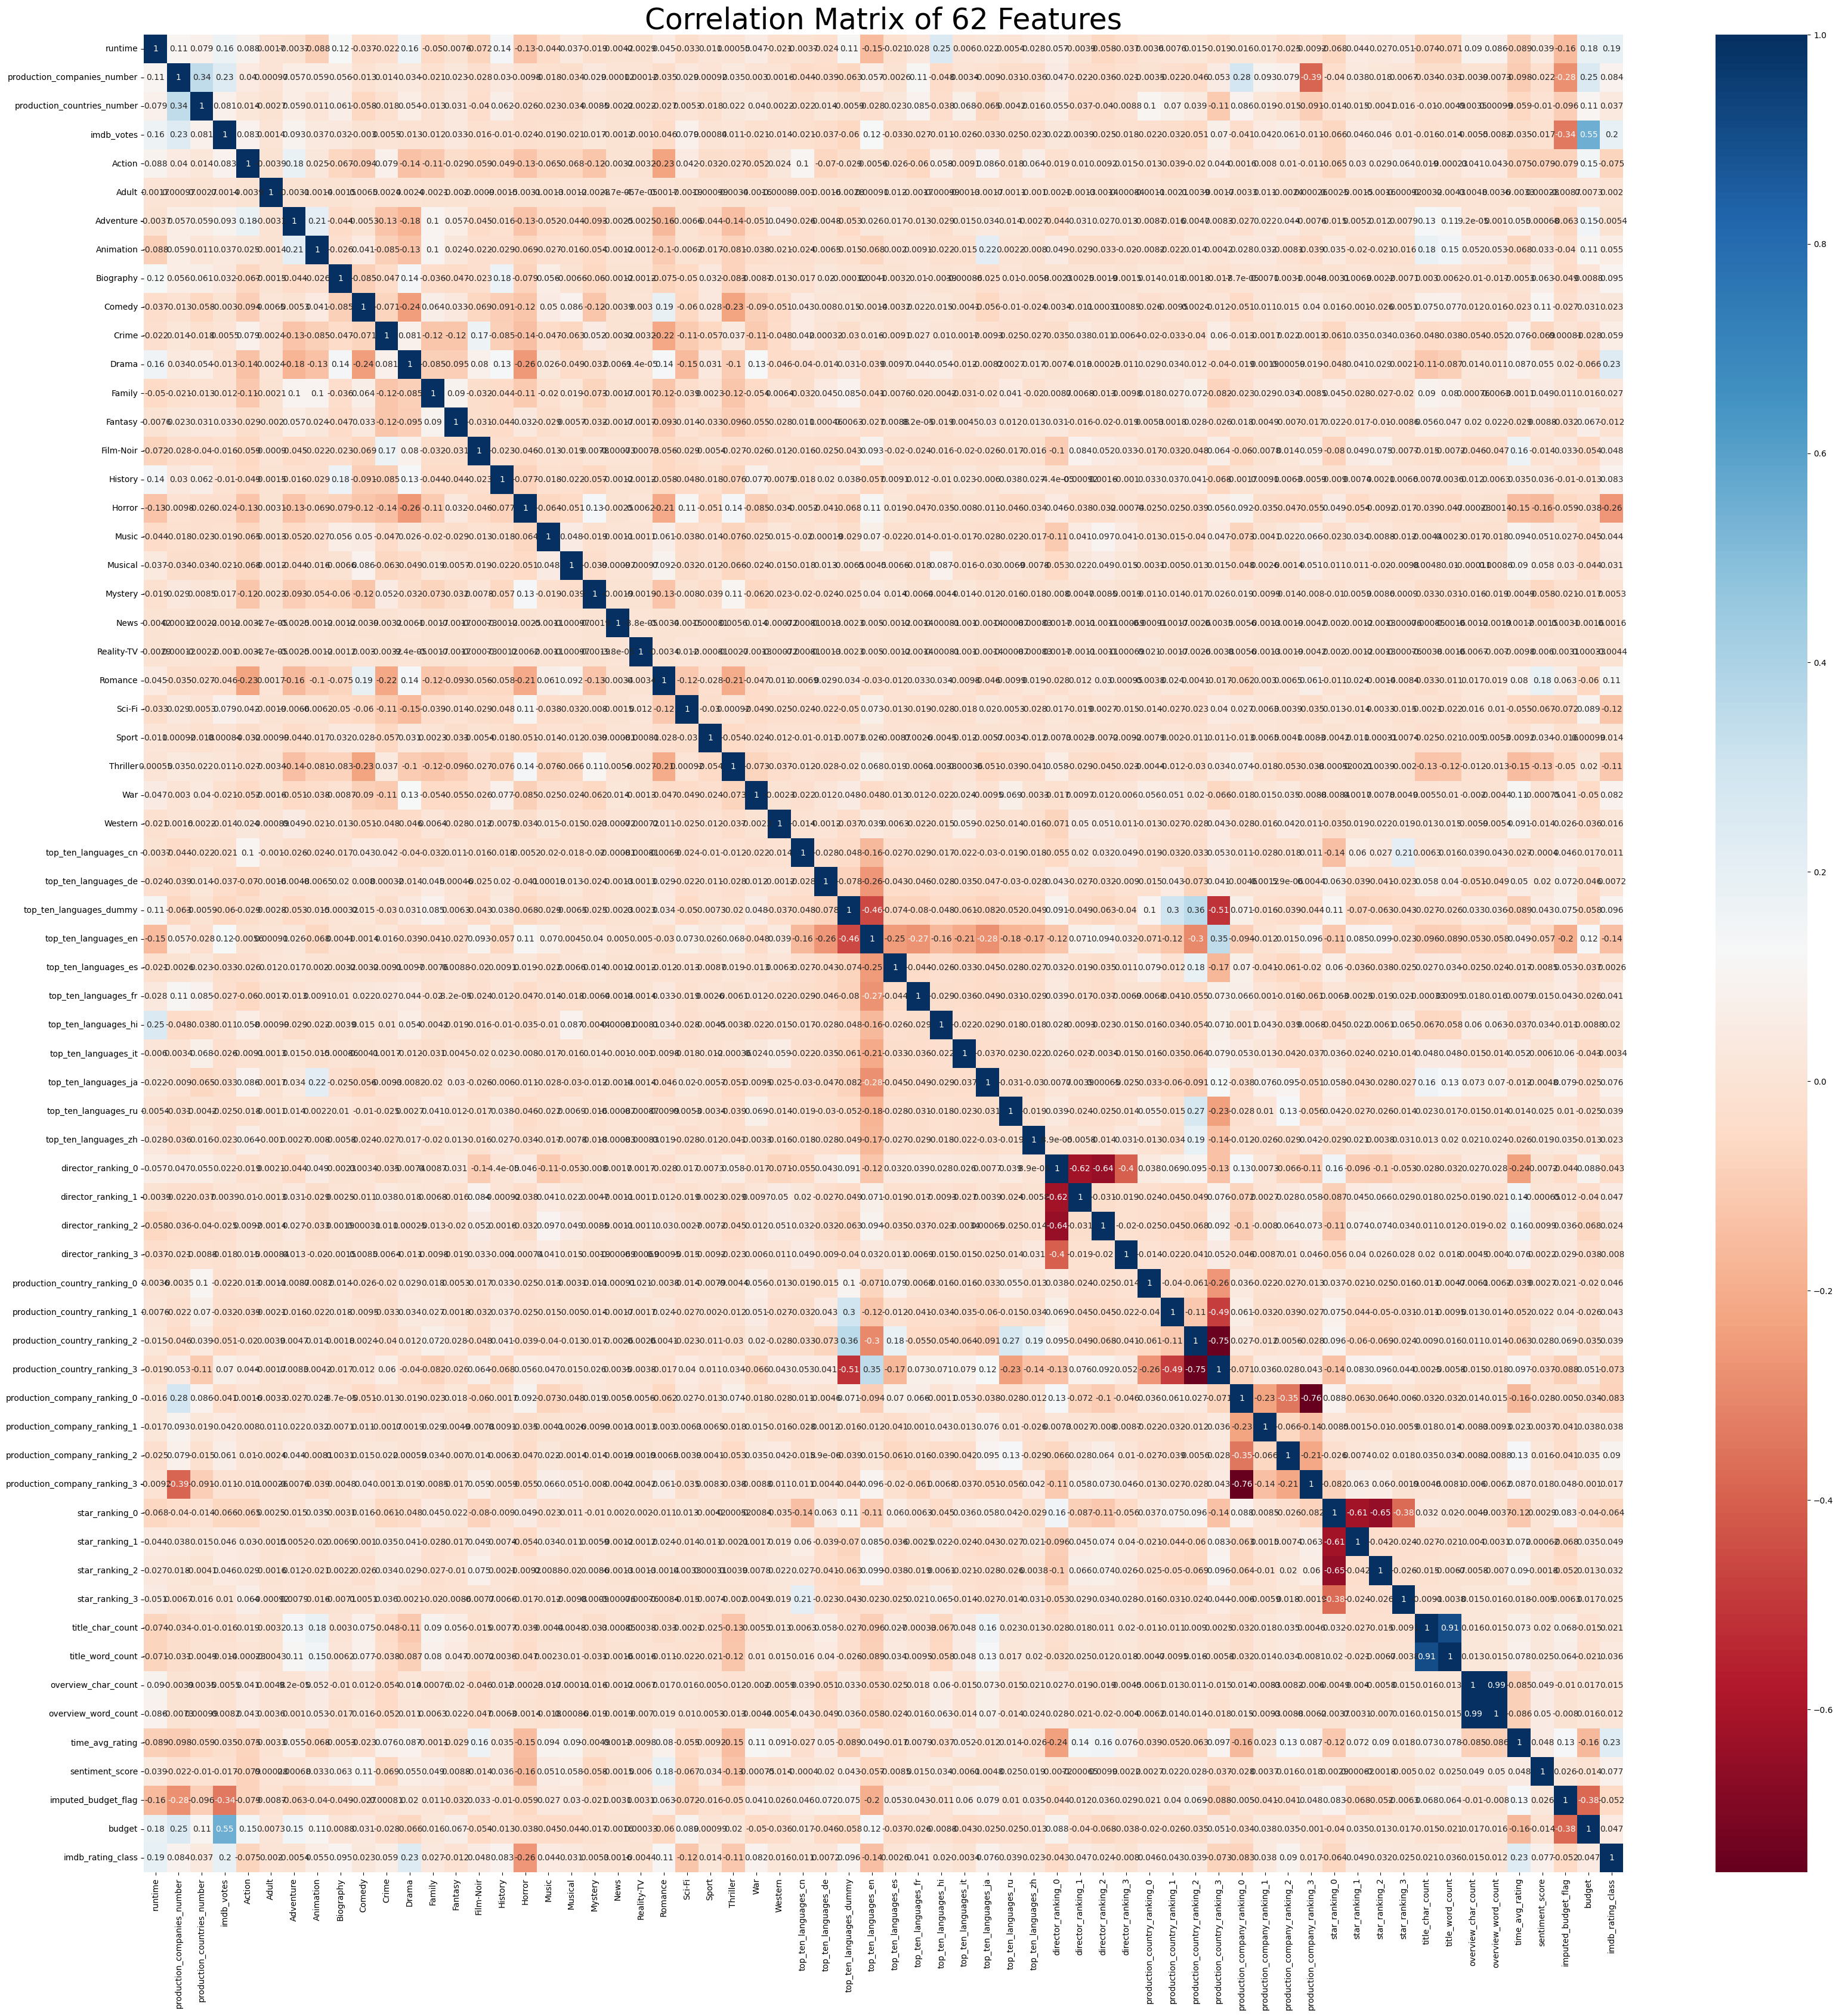

In [ ]:
# build correlation matrix for all features
fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(imdb_movies_final_df.corr(), annot=True, cmap='RdBu')
ax.set_title('Correlation Matrix of 62 Features', fontsize = 35)
plt.show()

From the above correlation matrix, it seems like the features aren't generally very correlated (which suggests fairly low redundancies). Given the number of original features, however, we decided to go ahead with PCA (performed in subsequent section) to exert less constraints on our machine learning algorithms. With sufficient variance captured from PCA, there should be very minimal accuracy loss in lieu of improved model simplicity.

## 3.2 Statistics Summary

The following presents statistics summary of select features. This will be the basis of choosing the different avenues we will explore in our EDA.

In [ ]:
movies_final_df[['imdb_rating', 'imdb_rating_class', 'budget', 'imdb_votes', 'runtime', 'sentiment_score']].describe()

imdb_rating  imdb_rating_class        budget    imdb_votes  \
count  52456.000000       52456.000000  5.245600e+04  5.245600e+04   
mean       5.908392           2.867279  9.234730e+06  1.515321e+04   
std        1.172453           0.509784  1.727705e+07  7.438807e+04   
min        1.000000           1.000000  2.640000e+02  5.000000e+00   
25%        5.200000           3.000000  1.670000e+06  1.340000e+02   
50%        6.100000           3.000000  5.575000e+06  6.490000e+02   
75%        6.700000           3.000000  1.000000e+07  3.319000e+03   
max        9.600000           4.000000  4.600000e+08  2.675531e+06   

            runtime  sentiment_score  
count  52456.000000     52456.000000  
mean      97.991078         0.033705  
std       23.748263         0.223886  
min        1.000000        -1.000000  
25%       86.000000        -0.067000  
50%       94.000000         0.006000  
75%      106.000000         0.150000  
max      999.000000         1.000000

## 3.3 Distribution of Rating Classes

We are interested in seeing the distribution of each `imdb_rating_class`.

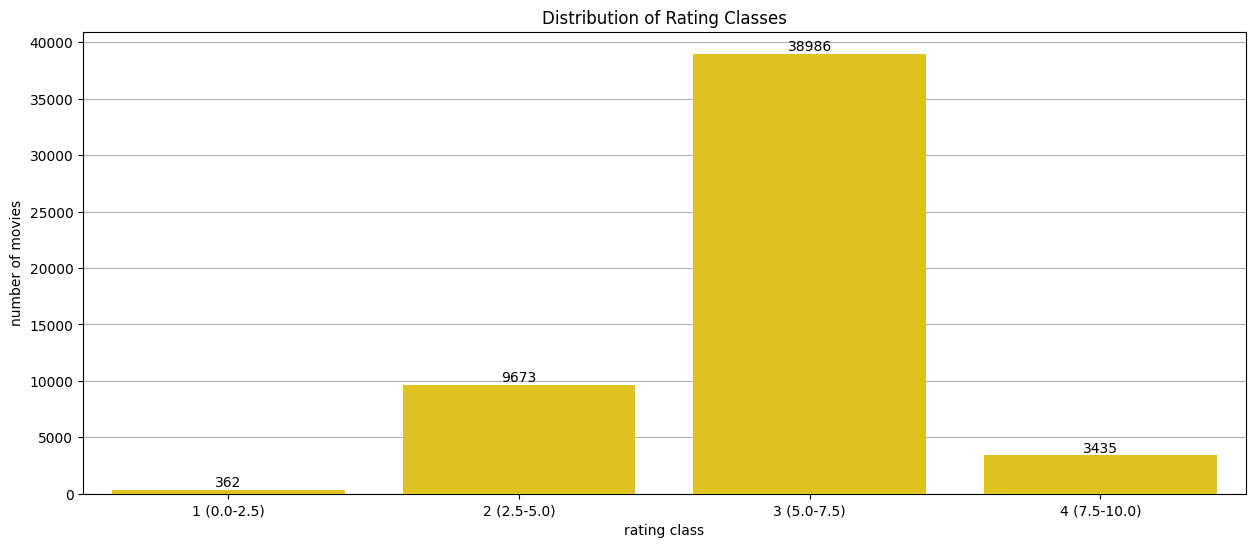

In [ ]:
# countplot for each rating class
fig, ax = plt.subplots(figsize=(15, 6))
ax.grid(axis='y', zorder=0)
sns.countplot(data=imdb_movies_final_df, x='imdb_rating_class', color='gold', zorder=3)
ax.set_title('Distribution of Rating Classes')
ax.set_xlabel('rating class')
ax.set_xticks(range(4), ['1 (0.0-2.5)', '2 (2.5-5.0)', '3 (5.0-7.5)', '4 (7.5-10.0)'])
ax.bar_label(ax.containers[0])
ax.set_ylabel('number of movies')
plt.show()

The above histogram shows an uneven distribution of rating class (e.g. majority of movie data falls into rating between 5.0 and 7.5). This calls for either random oversampling or balancing weights in response to the imbalanced nature of the dataset. These will be implemented in subsequent model building.

## 3.4 Movie Budget Effect on Rating

We are interested in seeing the correlation between `budget` and `imdb_rating`. Furthermore, we want to compute the average `budget` of each `imdb_rating_class`.

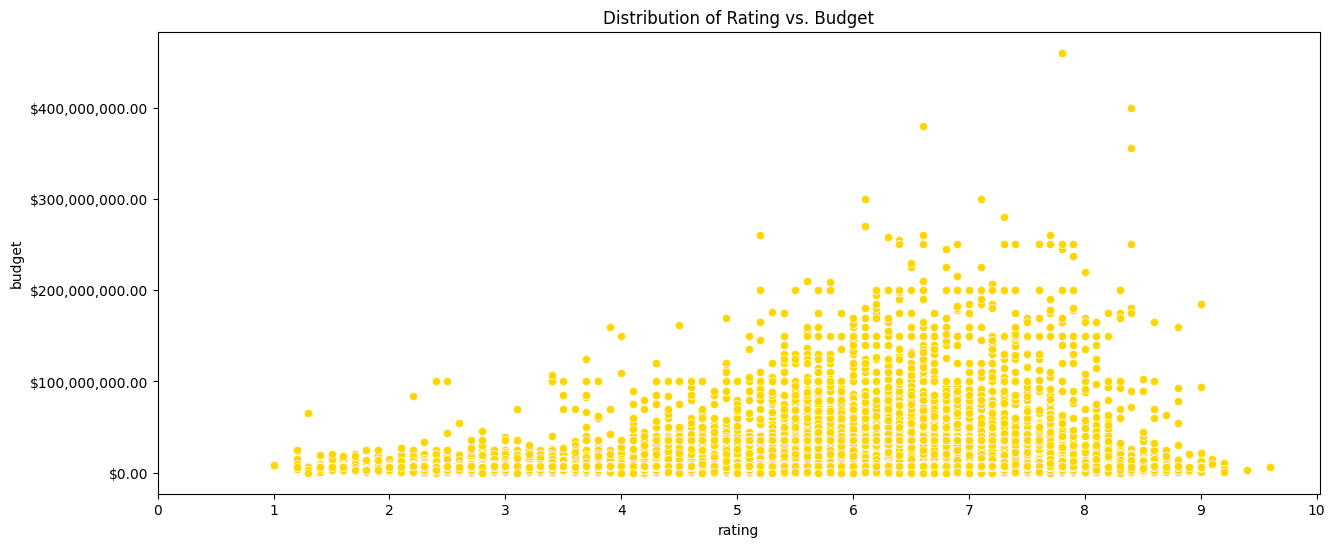

In [ ]:
# scatterplot of rating vs. budget
fig, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=movies_final_df[['budget', 'imdb_rating']], x='imdb_rating', y='budget', color='gold')
ax.set_title('Distribution of Rating vs. Budget')
ax.set_xlabel('rating')
ax.set_xticks(range(11), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax.set_ylabel('budget')
current_ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.2f}'.format(x) for x in current_ticks])
plt.show()

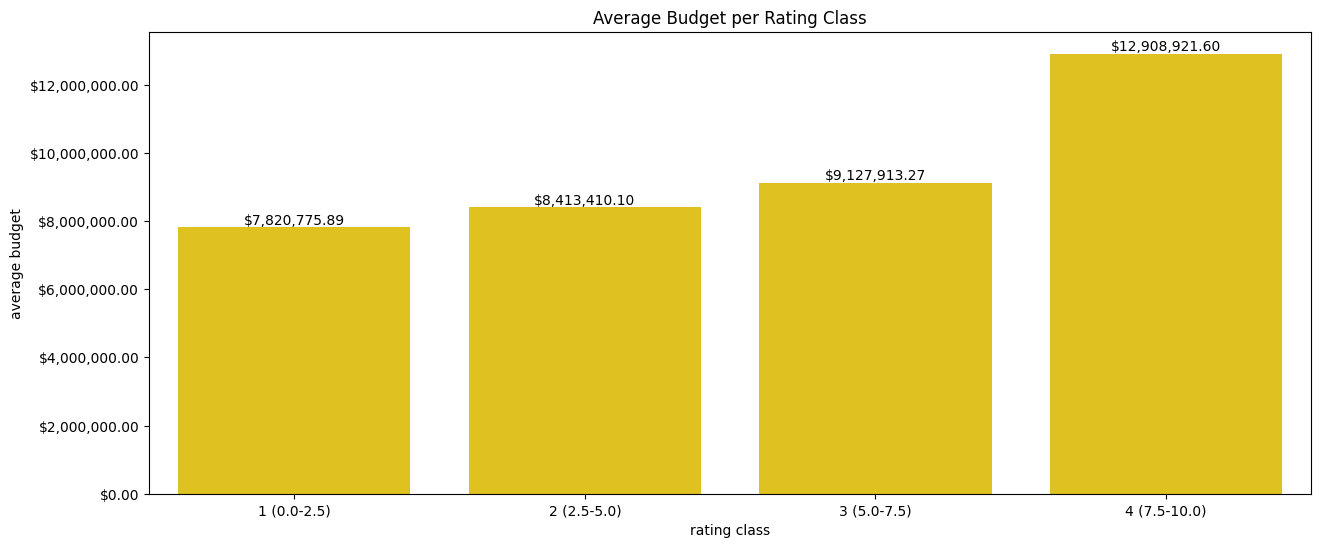

In [ ]:
# barplot of average budget per rating class
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=imdb_movies_final_df.groupby(['imdb_rating_class']).mean().reset_index(),
           x='imdb_rating_class',
           y='budget',
           color='gold')
ax.set_title('Average Budget per Rating Class')
ax.set_xlabel('rating class')
ax.set_xticks(range(4), ['1 (0.0-2.5)', '2 (2.5-5.0)', '3 (5.0-7.5)', '4 (7.5-10.0)'])
ax.bar_label(ax.containers[0], fmt='${:,.2f}')
ax.set_ylabel('average budget')
current_ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.2f}'.format(x) for x in current_ticks])
plt.show()

The above histogram shows a trend of increasing average budget with increasing movie rating classes. This should be expected as higher budget leads to more resources (e.g. bigger production company, more well-known cast, etc.). This might prompt a question of whether there's a correlation between budget and other features like production company, star, etc. or not, at which case PCA would be appropriate to help remove potential redundancies.

## 3.5 Movie Runtime Effect on Rating

We are interested in seeing the correlation between `runtime` and `imdb_rating`. Furthermore, we want to compute the average `runtime` of each `imdb_rating_class`.

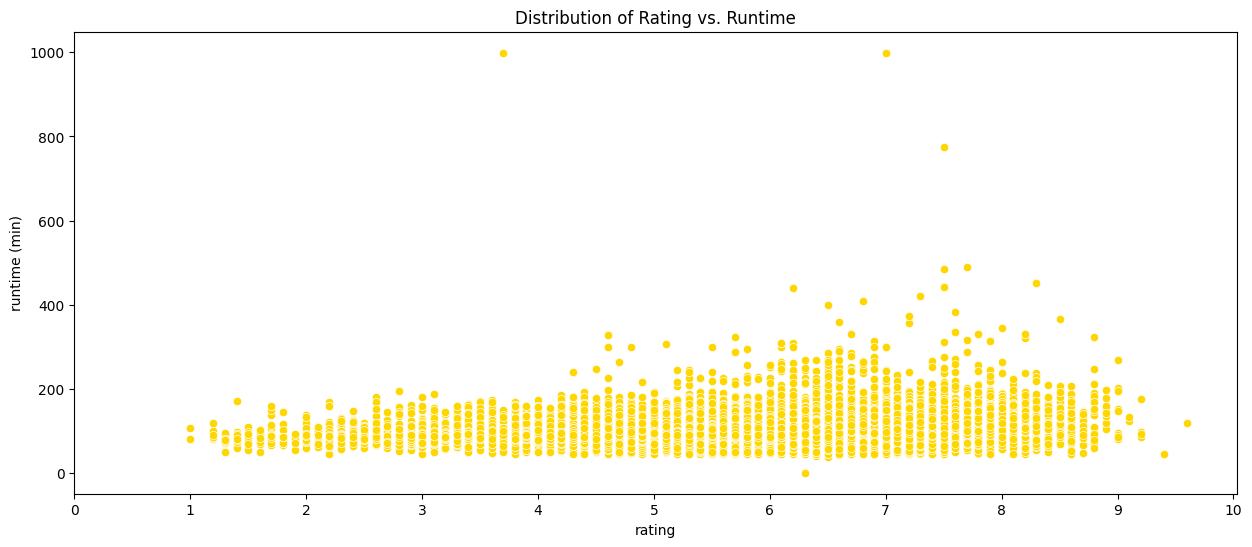

In [ ]:
# scatterplot of rating vs. runtime
fig, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=movies_final_df, x='imdb_rating', y='runtime', color='gold', zorder=3)
ax.set_title('Distribution of Rating vs. Runtime')
ax.set_xlabel('rating')
ax.set_xticks(range(11), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax.set_ylabel('runtime (min)')
plt.show()

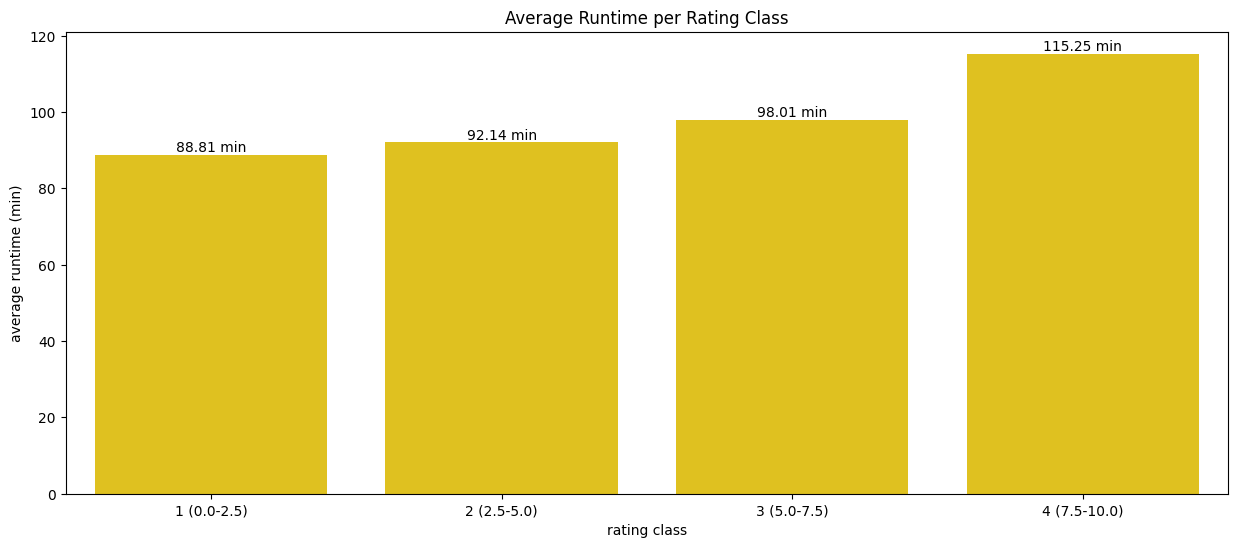

In [ ]:
# barplot of average votes per rating class
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=imdb_movies_final_df.groupby(['imdb_rating_class']).mean().reset_index(),
           x='imdb_rating_class',
           y='runtime',
           color='gold')
ax.set_title('Average Runtime per Rating Class')
ax.set_xlabel('rating class')
ax.set_xticks(range(4), ['1 (0.0-2.5)', '2 (2.5-5.0)', '3 (5.0-7.5)', '4 (7.5-10.0)'])
ax.bar_label(ax.containers[0], fmt='{:,.2f} min')
ax.set_ylabel('average runtime (min)')
current_ticks = plt.gca().get_yticks()
plt.show()

When looking at the scatterplot, one might not be able to see an obvious pattern in movie runtime vs. rating. The barplot, however, shows a trend of increasing average runtime with increasing movie rating classes. This might not be very intuitive initially, but our visualization helps us uncover such interesting insight.

## 3.6. Overview Sentiment Score Effect on Rating

We are interested in seeing the correlation between `sentiment_score` and `imdb_rating`.

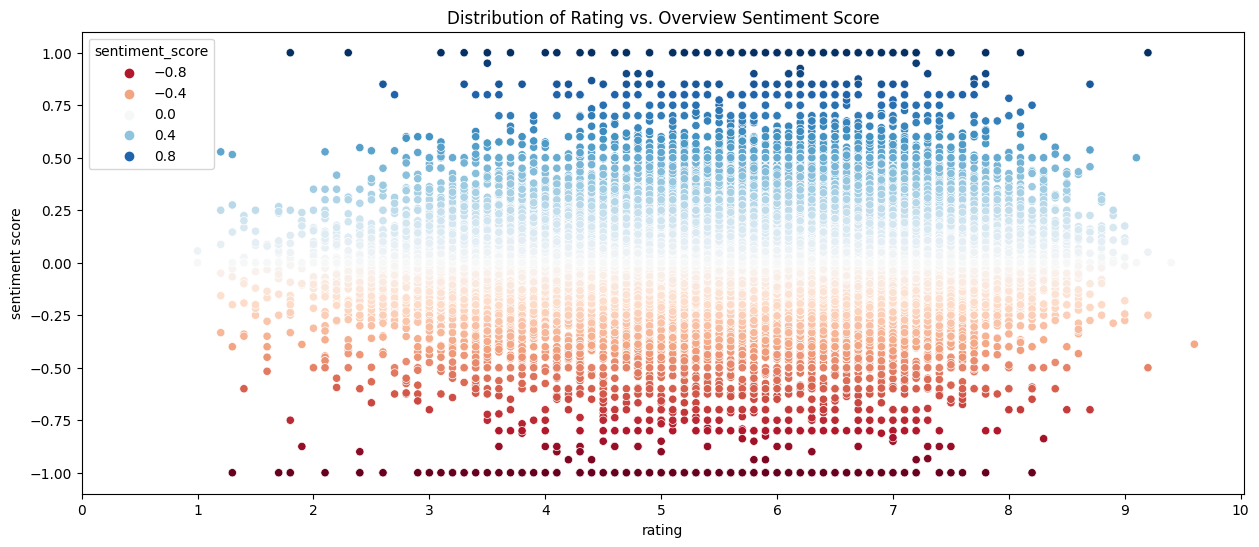

In [ ]:
# scatterplot of rating vs. sentiment score
fig, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=movies_final_df, x='imdb_rating', y='sentiment_score', hue='sentiment_score', palette='RdBu')
ax.set_title('Distribution of Rating vs. Overview Sentiment Score')
ax.set_xticks(range(11), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax.set_xlabel('rating')
ax.set_ylabel('sentiment score')
current_ticks = plt.gca().get_yticks()
plt.show()

Looking at the above scatterplot, there doesn't seem to be strong correlation between a movie overview's sentiment score with rating. We may expect sentiment score feature to be axed out of the principal components when PCA is implemented.

## 3.7 Top Countries by Number of Movies Produced

We are interested in seeing top countries with the most movies produced.

In [ ]:
# filter in only relevant columns
movies_per_country_df = movies_final_df[['production_countries', 'title']].groupby(['production_countries']).count().reset_index().sort_values(['title'], ascending=False)
movies_per_country_top30_df = movies_per_country_df.head(30)

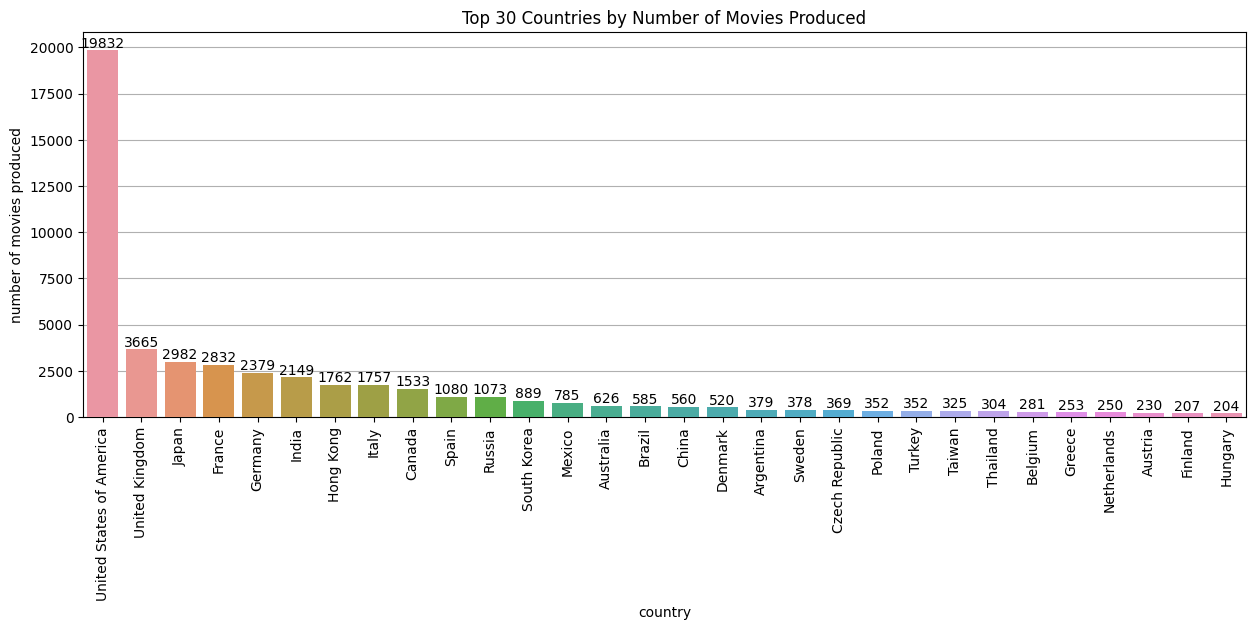

In [ ]:
# barplot of top 20 movie-producing countries
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(axis='y', zorder=0)
sns.barplot(data=movies_per_country_top30_df, x='production_countries', y='title', zorder=3)
ax.set_title('Top 30 Countries by Number of Movies Produced')
ax.set_xlabel('country')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('number of movies produced')
ax.bar_label(ax.containers[0])
plt.show()

The above histogram shows the US as the top movie-producing country at a staggering amount of 19,832 movies. There seems to be a huge drop between the US and the UK, the next top movie-producing country.

In [ ]:
# filter in only relevant columns
rating_per_top10_country_df = movies_final_df[['production_countries', 'imdb_rating']]\
                              [(movies_final_df['production_countries'] == 'United States of America') |\
                              (movies_final_df['production_countries'] == 'United Kingdom') |
                              (movies_final_df['production_countries'] == 'Japan') |
                              (movies_final_df['production_countries'] == 'France') |
                              (movies_final_df['production_countries'] == 'Germany') |
                              (movies_final_df['production_countries'] == 'India') |
                              (movies_final_df['production_countries'] == 'Hong Kong') |
                              (movies_final_df['production_countries'] == 'Italy') |
                              (movies_final_df['production_countries'] == 'Canada') |
                              (movies_final_df['production_countries'] == 'Spain')]\
                              .groupby(['production_countries']).mean().reset_index().sort_values(['imdb_rating'], ascending=False)

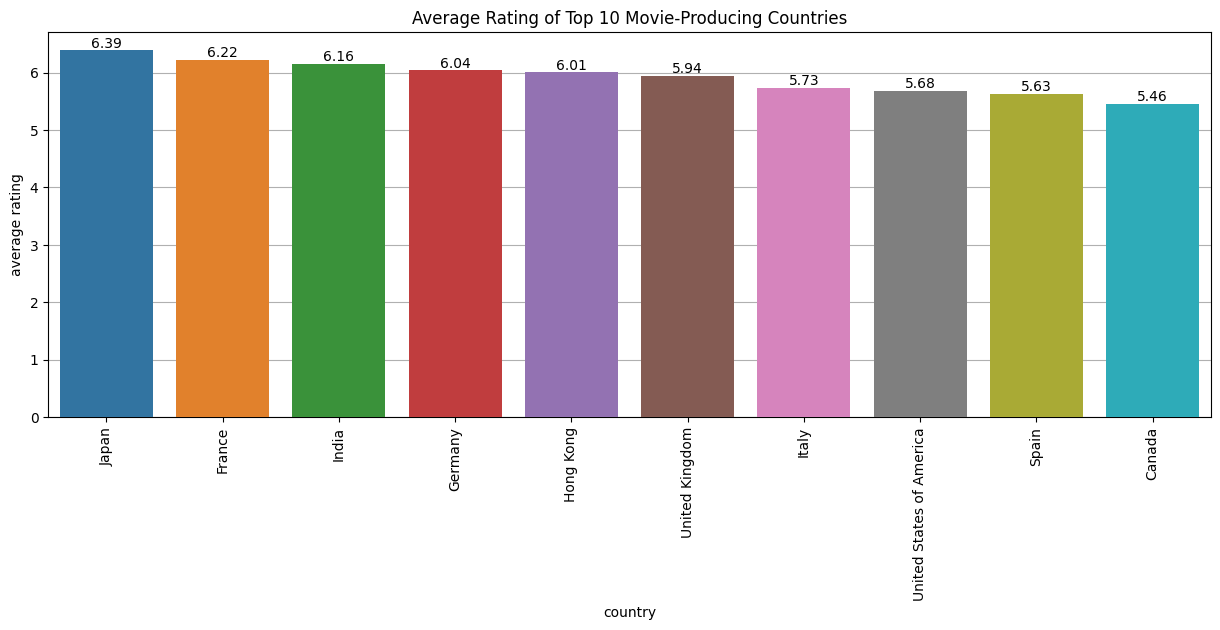

In [ ]:
# barplot of average rating of top 10 movie-producing countries
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(axis='y', zorder=0)
sns.barplot(data=rating_per_top10_country_df, x='production_countries', y='imdb_rating', zorder=3)
ax.set_title('Average Rating of Top 10 Movie-Producing Countries')
ax.set_xlabel('country')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('average rating')
ax.bar_label(ax.containers[0], fmt='{:,.2f}')
plt.show()

The above histogram shows that top movie-producing country doesn't necessarily mean having highest average rating. For example, the US as the top movie-producing country falls behind 7 other countries on the average rating.

# 4. Standardization and Principal Component Analysis (PCA)


---



We now want to apply PCA on our dataset to reduce dimensionality and minimize redundancies. Because PCA is scale-invariant, it is desirable to standardize/scale our features first.

## 4.1 Scaling

In [ ]:
# split imdb_movies_final_df into imdb_features and imdb_target dataframes
imdb_features = imdb_movies_final_df.drop(columns=['imdb_rating_class'])
imdb_target = imdb_movies_final_df[['imdb_rating_class']]

In [ ]:
# split data into 80/20 train-test set
random_state = 55
imdb_X_train, imdb_X_test, imdb_y_train, imdb_y_test = train_test_split(imdb_features, imdb_target, test_size=0.2, random_state=random_state)

In [ ]:
# standardize data
scaler = StandardScaler()
scaler.fit(imdb_X_train)
imdb_X_train_sc = scaler.transform(imdb_X_train)
imdb_X_test_sc = scaler.transform(imdb_X_test)

## 4.2 PCA

We want to know how far down we need to reduce the dimensionality to keep much of the variance above a certain threshold (we will set as 85%). To do so, we will first plot number of components (total = 62) vs. explained variance ratio.

In [ ]:
# instantiate and fit PCA onto train dataset
pca = PCA(n_components=imdb_features.shape[1])
pca.fit(imdb_X_train_sc)
imdb_X_train_pca = pca.transform(imdb_X_train_sc)

In [ ]:
# store PCA's explained variance ratios
imdb_explained_variance_ratios = pca.explained_variance_ratio_

# store the cumulative explained variance ratios
imdb_cum_vr = np.cumsum(imdb_explained_variance_ratios)

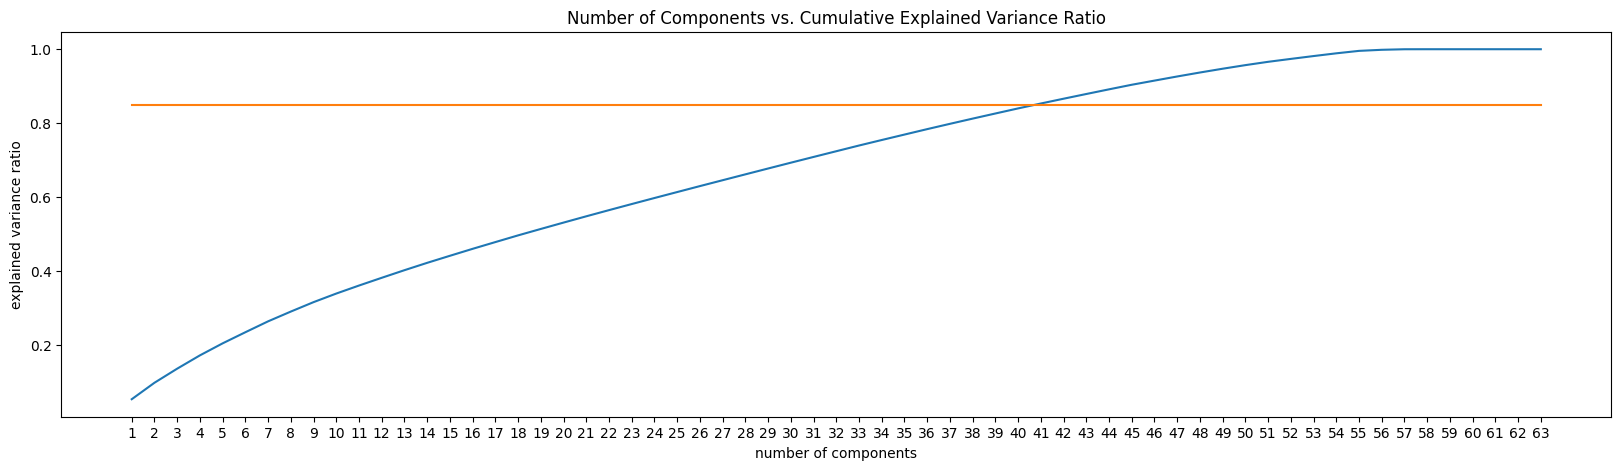

In [ ]:
# plot of number of components vs. explained variance ratio to determine optimal number of components to use
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(imdb_cum_vr)
sns.lineplot(np.linspace(0.85, 0.85, len(imdb_cum_vr)))
ax.set_title('Number of Components vs. Cumulative Explained Variance Ratio')
ax.set_xlabel('number of components')
ax.set_ylabel('explained variance ratio')
ax.set_xticks(np.arange(len(imdb_cum_vr)), np.arange(1, len(imdb_cum_vr)+1))
plt.show()

From the above plot, we will decide on keeping 41 components for our PCA. This will ensure at least 85% of explained variance of our original dataset. Upon completion, we will finally be ready to feed the scaled and PCA-ed features into our model training.

In [ ]:
# refit and transform on training set with decided number of components
n_optimal = 41
pca = PCA(n_components=n_optimal)
pca.fit(imdb_X_train_sc)

PCA(n_components=41)

In [ ]:
# transform on train and test set
imdb_X_train_pca = pca.transform(imdb_X_train_sc)
imdb_X_test_pca = pca.transform(imdb_X_test_sc)

# 5. Feedforward Neural Network (FNN)


---



We will train a neural network, since it's known to be able to pick out trends in classification problems.

## 5.0 Setup
Setting random seeds, putting data into dataloader

In [ ]:
# transform targets to be in [0,3]
imdb_y_train_fnn = imdb_y_train.copy()
imdb_y_test_fnn = imdb_y_test.copy()
imdb_y_train_fnn['imdb_rating_class'] = imdb_y_train['imdb_rating_class'].apply(lambda x: x-1)
imdb_y_test_fnn['imdb_rating_class'] = imdb_y_test['imdb_rating_class'].apply(lambda x: x-1)

In [ ]:
# for setting random seed
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [ ]:
# set up gpu device and seed
torch.manual_seed(55)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class MyDataset(Dataset):

  def __init__(self,x, y):
    self.x_train=torch.tensor(x,dtype=torch.float32) # x is numpy array
    self.y_train=torch.tensor(y.values,dtype=torch.float32) # y is not numpy array

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [ ]:
# put data into dataset
imdb_train_pca_dataset = MyDataset(imdb_X_train_pca, imdb_y_train_fnn)
imdb_test_pca_dataset = MyDataset(imdb_X_test_pca, imdb_y_test_fnn)

In [ ]:
# put data into dataloader
batch = 64
imdb_train_pca_dataloader = torch.utils.data.DataLoader(imdb_train_pca_dataset, batch_size = batch, shuffle = True, num_workers = 0)
imdb_test_pca_dataloader = torch.utils.data.DataLoader(imdb_test_pca_dataset, batch_size = batch, shuffle = True, num_workers = 0)

## 5.1 Functions for testing
Note that training is not written as a function because training requires multiple passes across a dataloader, which is less conducive to being put into a function.

In [ ]:
# inputs: confusion matrix as df, label for title
# prints confusion matrix
# outputs: void
def print_cm(confusion_matrix_df, label = None):
  fig, ax = plt.subplots(figsize=(8,4))
  sns.heatmap(confusion_matrix_df,
              annot=True,
              fmt='g',
              cmap='GnBu',
              xticklabels=['1 (0.0-2.5)', '2 (2.5-5.0)', '3 (5.0-7.5)', '4 (7.5-10.0)'],
              yticklabels=['1 (0.0-2.5)', '2 (2.5-5.0)', '3 (5.0-7.5)', '4 (7.5-10.0)'])
  ax.set_title('Confusion Matrix: ' + label)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  plt.show()

In [ ]:
# inputs: trained model, dataloader for testing data,
# (optional) label for printing
# outputs: test accuracy, confusion matrix as a df
def test(model, dataloader, label = None):
  if (label != None):
    print("Testing: " + label)
  else:
    print("Testing...")
  print("=====")

  total = 0
  correct = 0
  true = []
  predicted = []
  with torch.no_grad():
      for inputs, labels in dataloader:
          labels = labels.type(torch.LongTensor)
          labels = labels.flatten()
          inputs, labels = inputs.to(device), labels.to(device)

          # Get outputs
          outputs = model(inputs)
          preds = torch.argmax(outputs, axis=1)

          # Update running totals
          correct += sum(preds == labels)
          total += len(preds)

          # Add to true labels and predicted labels
          true.extend(x.item() + 1 for x in labels.cpu())
          predicted.extend(x.item() + 1 for x in preds.cpu())

  # Calculate and display test accuracy
  accuracy = 100 * correct / total
  accuracy = accuracy.item()
  print('Test Accuracy: ' + str(accuracy))
  print("=====")

  # Calculate and display test accuracy for each category
  print("Class-wise prediction accuracy: ")
  for i in range(1, 5):
    print("Class " + str(i) + ": " +
          str(100 * sum((np.array(true)==i) & (np.array(predicted) == i))/sum(np.array(true) == i)))

  return accuracy, pd.DataFrame(data = confusion_matrix(true, predicted))


## 5.2 Building FNN model
After hyperparameter tuning, this architecture performed the best.

In [ ]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = torch.nn.Linear(in_features = 41, out_features = 64)
        self.linear2 = torch.nn.Linear(in_features = 64, out_features = 32)
        self.linear3 = torch.nn.Linear(in_features = 32, out_features = 4)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        outputs = self.flatten(x)
        outputs = self.linear1(outputs)
        outputs = self.relu(outputs)
        outputs = self.linear2(outputs)
        outputs = self.relu(outputs)
        outputs = self.linear3(outputs)
        return outputs

## 5.3 First train and test of FNN model

In [ ]:
%%time
dataloader = imdb_train_pca_dataloader
l_step = 1e-5
weight_decay = 0.00
epoch = 10

print("Training...")
print("Learning step: " + str(l_step))
print("Weight decay: " + str(weight_decay))
print("Epochs: " + str(epoch))
print("=====")

random_seed(55, True)
imdb_fnn_pca = FNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(imdb_fnn_pca.parameters(),
                        lr=l_step, weight_decay = weight_decay)
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in dataloader:
      labels = labels.type(torch.LongTensor)
      labels = labels.flatten()
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = imdb_fnn_pca(inputs)
      preds = torch.argmax(outputs, axis = 1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      total += len(labels)
      correct += sum(labels == preds)

  accuracy = (100 * correct) / total
  print("Epoch " + str(epoch) + ": loss " + str(running_loss/len(dataloader)) +
        ", accuracy " + str(accuracy.item()))

Training...
Learning step: 1e-05
Weight decay: 0.0
Epochs: 10
=====
Epoch 0: loss 1.2106337258365096, accuracy 74.00390625
Epoch 1: loss 1.1112854200892333, accuracy 74.28986358642578
Epoch 2: loss 1.0067948410060348, accuracy 74.28986358642578
Epoch 3: loss 0.913483499390323, accuracy 74.28986358642578
Epoch 4: loss 0.8454327838631664, accuracy 74.28986358642578
Epoch 5: loss 0.8012141432703995, accuracy 74.28986358642578
Epoch 6: loss 0.7719146299471216, accuracy 74.28986358642578
Epoch 7: loss 0.7508025330196066, accuracy 74.28986358642578
Epoch 8: loss 0.7337300395365896, accuracy 74.28986358642578
Epoch 9: loss 0.7195501127166719, accuracy 74.28986358642578
CPU times: user 17.4 s, sys: 1.05 s, total: 18.5 s
Wall time: 19.7 s


In [ ]:
# test
_, imdb_pca_cm= test(imdb_fnn_pca, imdb_test_pca_dataloader)

Testing...
=====
Test Accuracy: 74.44719696044922
=====
Class-wise prediction accuracy: 
Class 1: 0.0
Class 2: 0.0
Class 3: 100.0
Class 4: 0.0


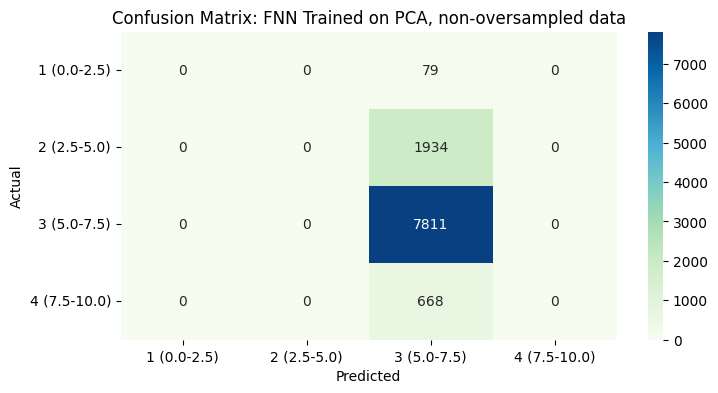

In [ ]:
# print confusion matrix
print_cm(imdb_pca_cm, "FNN Trained on PCA, non-oversampled data")

The accuracies on the train and test data are both calculated as around 74%, which seems pretty good. But this is misleading, and the seemingly high accuracy is due to class imbalance effects, which can be seen in the correlation matrix. With the data as-is, the neural network simply predicts everything as class 3, which isn't able to capture any nuance. We can try to solve this by oversampling.

## 5.4 Add oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros=RandomOverSampler(random_state = 55)
imdb_X_train_ros,imdb_y_train_ros=ros.fit_resample(imdb_X_train_pca,imdb_y_train_fnn)
imdb_X_test_ros,imdb_y_test_ros=ros.fit_resample(imdb_X_test_pca,imdb_y_test_fnn)

imdb_train_ros_dataset = MyDataset(imdb_X_train_ros, imdb_y_train_ros)
imdb_test_ros_dataset = MyDataset(imdb_X_test_ros, imdb_y_test_ros) # test ROS
imdb_train_ros_dataloader = torch.utils.data.DataLoader(imdb_train_ros_dataset, batch_size = batch, shuffle = True, num_workers = 0)
imdb_test_ros_dataloader = torch.utils.data.DataLoader(imdb_test_ros_dataset, batch_size = batch, shuffle = True, num_workers = 0)

## 5.5 Training on oversampled data, and tests

In [ ]:
# training
%%time
dataloader = imdb_train_ros_dataloader
l_step = 1e-5 # after hyperparameter tuning, these performed the best
weight_decay = 0.00
epoch = 15

print("Training...")
print("Learning step: " + str(l_step))
print("Weight decay: " + str(weight_decay))
print("Epochs: " + str(epoch))
print("=====")

random_seed(55, True)
imdb_fnn_ros = FNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(imdb_fnn_ros.parameters(),
                        lr=l_step, weight_decay = weight_decay)
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in dataloader:
      labels = labels.type(torch.LongTensor)
      labels = labels.flatten()
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = imdb_fnn_ros(inputs)
      preds = torch.argmax(outputs, axis = 1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      total += len(labels)
      correct += sum(labels == preds)

  accuracy = (100 * correct) / total
  print("Epoch " + str(epoch) + ": loss " + str(running_loss/len(dataloader)) +
        ", accuracy " + str(accuracy.item()))

Training...
Learning step: 1e-05
Weight decay: 0.0
Epochs: 15
=====
Epoch 0: loss 1.3714526992629528, accuracy 27.17481803894043
Epoch 1: loss 1.2854811186176376, accuracy 43.63271713256836
Epoch 2: loss 1.1833900122106717, accuracy 47.757015228271484
Epoch 3: loss 1.114002858509829, accuracy 48.923011779785156
Epoch 4: loss 1.0768006778852093, accuracy 50.39133834838867
Epoch 5: loss 1.055184786658583, accuracy 51.809940338134766
Epoch 6: loss 1.0404769832076264, accuracy 52.508419036865234
Epoch 7: loss 1.0291715571059514, accuracy 53.234962463378906
Epoch 8: loss 1.01971224909137, accuracy 53.724937438964844
Epoch 9: loss 1.0113335869262132, accuracy 53.99117660522461
Epoch 10: loss 1.0037580646570674, accuracy 54.477142333984375
Epoch 11: loss 0.9966567655047617, accuracy 54.66639709472656
Epoch 12: loss 0.9899957692886145, accuracy 55.02004623413086
Epoch 13: loss 0.9836911509561808, accuracy 55.25981903076172
Epoch 14: loss 0.9777180356450911, accuracy 55.63993453979492
CPU times

In [ ]:
# testing on non-oversampled data
_, imdb_ros_pca_cm = test(imdb_fnn_ros, imdb_test_pca_dataloader,
                          label = "Model trained on oversampled data using non-oversampled data")

Testing: Model trained on oversampled data using non-oversampled data
=====
Test Accuracy: 43.995426177978516
=====
Class-wise prediction accuracy: 
Class 1: 68.35443037974683
Class 2: 37.33195449844881
Class 3: 43.016259121751375
Class 4: 71.8562874251497


Overall, a test accuracy of 42.8% isn't that great, but it's at least better than random guessing. We can see that the neural net is having the most difficulty predicting Class 2 and Class 3 movies. We can also see some overfitting - train accuracy got as high as 55.9%.

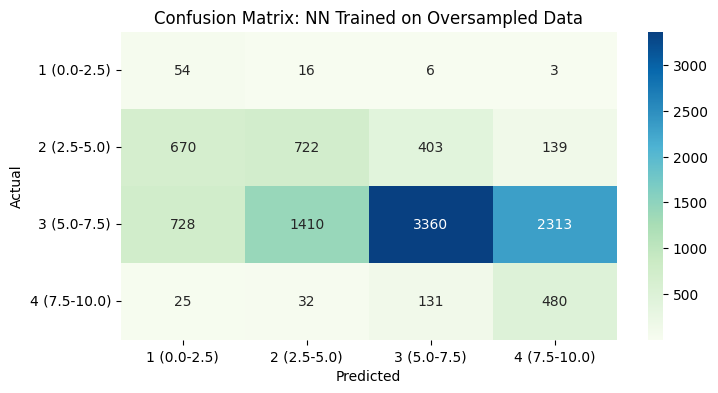

In [ ]:
# showing confusion matrix
print_cm(imdb_ros_pca_cm, "NN Trained on Oversampled Data")

The confusion matrix looks a bit imbalanced due to the sheer amount of class 3 movies as compared to other types, but it looks much better than with the previous model without resampling. Note that in each row of the confusion matrix, the entry with the highest value corresponds to the class that actually belongs to that row. This is pretty promising, and points to at least some sort of structure in the data that can be used to differentiate between classes, even if the neural network was unable to find it.

## 5.6 Limitations of FNN
Overall, the accuracy of the FNN for predicting these movie classifications is very low. This can be due to a couple of reasons:
- Neural networks tend to overfit, as demonstrated. While creating the model, even with weight decay, as the train accuracy increased with different hyperparameters and model architectures, test accuracy would begin to decrease as train accuracy reached over 55%. This would probably be fixed with more data to train on, which brings us to the second point...
- Neural networks require lots of data to train properly, and we only had about 40k training rows to work with, using an 80/20 train/test split.

So this has shown that neural networks aren't a very good tool for this specific data problem. We'll try some other models in the following sections.

# 6. Decision Tree
---
Intuition:

One particular advantage in using Decision Tree for our classification problem in addition to its intuitivity comes from how we organized our one-hot encodings. The intermediate question that we ask ourselves is:
* Are we able to classify a movie just from the 'grouping' of its director, actor, and production backgrounds?

Since we aggregated relevant informations of each movie into top 3, 2, 1, 0, categorically, a Decision Tree comes to be a good classifier to answer our intermediate question by 'categorically' breaking the question down to:
* if production company `x` have had experience producing a lot more movies because it's in group 3, does that mean movie `y` will have a good rating?
---
Process Overview:

Now, to begin with our Decision Tree, first use GridSearchCV to fine-tune the hyper parameters. After getting the most optipal parameter results, create the Decision Tree using the result and display it using a confusion matrix. Note also that we initialize our Decision Tree classifier using `class_weight='balanced'` for its modeling to reduce biases in our result.

### 6.1 Fine-tuning hyperparameters
---

In [ ]:
# Define the values for max_depth & criterion
param_grid = {'max_depth': [10, 12, 14, 16],
              'min_samples_split': [4, 6, 8, 10],
              }

# Initialize a decision tree classifier
dt = DecisionTreeClassifier(class_weight='balanced')

# Create a grid search object and fit training data
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(pca.fit_transform(imdb_X_train_sc), imdb_y_train)

# Get the best hyperparameters and accuracy
best_dt = grid_search.best_estimator_
accuracy_test = best_dt.score(imdb_X_test_pca, imdb_y_test)

print("Best max_depth:", best_dt.get_params()['max_depth'])
print("Best min_samples_split:", best_dt.get_params()['min_samples_split'])


Best max_depth: 16
Best min_samples_split: 4


acc: 0.5322150209683568


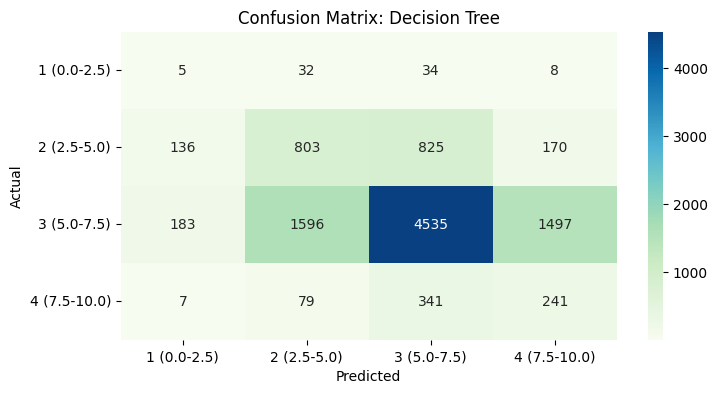

In [ ]:
# initialize and fit DecisionTree with fine-tuned hyperparameter
dt = DecisionTreeClassifier(max_depth=16, min_samples_split=4, class_weight='balanced')
dt.fit(pca.fit_transform(imdb_X_train_sc), imdb_y_train)

# Make predictions on the testing data
y_pred = dt.predict(imdb_X_test_pca)

# Evaluate the performance of the classifier on testing
accuracy_test = dt.score(imdb_X_test_pca, imdb_y_test)
print("acc: " + str(accuracy_test))

# Create confusion matrix
dt_cm = confusion_matrix(imdb_y_test, y_pred)

print_cm(dt_cm, 'Decision Tree')

### 6.2 Performance
---
We achieved around 55% accuracy using Decision Tree for our classification problem which is not the best. However, one important note is that 55% accuracy is obtained in consideration of biases. Without adjusting for biases, Decision Tree can achieve up to 75% accuracy. Therefore, while Decision Tree can be a good prediction model without accounting for biases, we still need a better model to taking biases into account.

# 7. Logistic Regression


---



Logistic regression is a widely used for prediction and classification models, which serves for the purpose of predicting movie rating class. We now want to attempt building multiclass logistic regression models, both unregularized and regularized (with hyperparameters tuning). We want to look at prediction accuracy when comparing the performance of the two approaches.

In [ ]:
# import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

## 7.1 Unregularized

In [ ]:
# initialize unregularized model
logreg_ur = LogisticRegression(multi_class='ovr', class_weight='balanced', penalty='none', max_iter=100)

# fit model on the train dataset
logreg_ur.fit(imdb_X_train_pca, imdb_y_train)

# use model to make prediction on the test set
logreg_ur_y_train_pred = logreg_ur.predict(imdb_X_train_pca)
logreg_ur_y_test_pred = logreg_ur.predict(imdb_X_test_pca)

# compute prediction accuracy on train and test dataset
logreg_ur_train_acc = logreg_ur.score(imdb_X_train_pca, imdb_y_train)
logreg_ur_test_acc = logreg_ur.score(imdb_X_test_pca, imdb_y_test)

In [ ]:
# print out results
print('Model: Unregularized Multiclass Logistic Regression')
print('Prediction accuracy on train set: ', logreg_ur_train_acc*100, '%')
print('Prediction accuracy on test set: ', logreg_ur_test_acc*100, '%')

Model: Unregularized Multiclass Logistic Regression
Prediction accuracy on train set:  53.15031932132304 %
Prediction accuracy on test set:  53.42165459397636 %


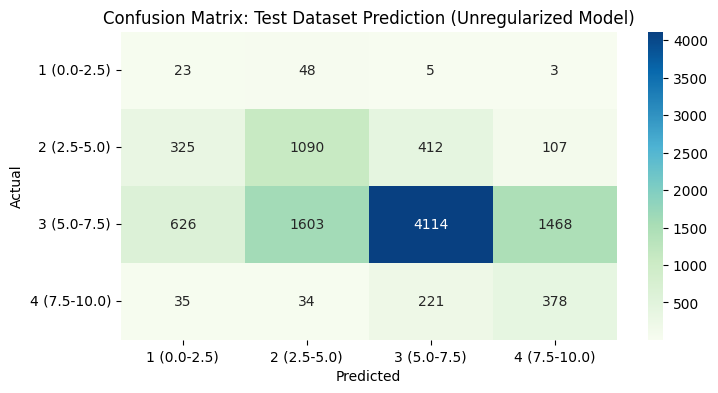

In [ ]:
# compute the confusion matrix
logreg_ur_test_cm = confusion_matrix(y_true=imdb_y_test, y_pred=logreg_ur_y_test_pred)

print_cm(logreg_ur_test_cm, 'Test Dataset Prediction (Unregularized Model)')

## 7.2 Regularized with Hyperparameters Tuning

We will now attempt to build a regularized model to hopefully maximize predictive accuracy. Additionally, we will attempt to do hyperparameter tuning using `GridSearchCV`. The main hyperparameters to tune are as follows:
- `C` (regularization strength; takes a value of positive float)
- `penalty` (takes a value of `l1` for Lasso or `l2` for Ridge).

`class_weight` is set as `balanced` in response to the imbalance nature of the dataset to avoid prediction bias .

`multi_class` is set as `ovr` for one-vs-rest algorithm in multiclass classification.

`solver` is set as `liblinear` as limited by one-vs-rest algorithm.


In [ ]:
# initialize regularized model
logreg_r = LogisticRegression()

# define hyperparameters to optimize
grid = {'penalty':['l1', 'l2'],
        'C':np.logspace(-3,3,50)}

# instantiate GridSearchCV
logreg_r_cv = GridSearchCV(logreg_r, grid, cv=10, verbose=True, n_jobs=-1)

# fit model on training set
logreg_r_cv.fit(imdb_X_train_pca, imdb_y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-...
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=True)

In [ ]:
print('Hyperparameters tuning result')
print('Best penalty: ', logreg_r_cv.best_params_['penalty'])
print('Best C: ', logreg_r_cv.best_params_['C'])
print("Accuracy :", logreg_r_cv.best_score_)

Hyperparameters tuning result
Best penalty:  l2
Best C:  25.595479226995334
Accuracy : 0.7686113123155515


In [ ]:
# initialize regularized model (with hyperparameters tuned)
logreg_r_hyptun = LogisticRegression(penalty='l2',
                                     C=104.81131341546852,
                                     class_weight='balanced',
                                     max_iter=2000,
                                     multi_class='ovr',
                                     solver='liblinear')

# fit model on training set
logreg_r_hyptun.fit(imdb_X_train_pca, imdb_y_train)

# use model to make prediction on the test set
logreg_r_hyptun_y_train_pred = logreg_r_hyptun.predict(imdb_X_train_pca)
logreg_r_hyptun_y_test_pred = logreg_r_hyptun.predict(imdb_X_test_pca)

# compute prediction accuracy on train and test dataset
logreg_r_hyptun_train_acc = logreg_r_hyptun.score(imdb_X_train_pca, imdb_y_train)
logreg_r_hyptun_test_acc = logreg_r_hyptun.score(imdb_X_test_pca, imdb_y_test)

In [ ]:
# print out results
print('Model: Regularized Multiclass Logistic Regression with Tuned Hyperparameters')
print('Prediction accuracy on train set: ', logreg_r_hyptun_train_acc*100, '%')
print('Prediction accuracy on test set: ', logreg_r_hyptun_test_acc*100, '%')

Model: Regularized Multiclass Logistic Regression with Tuned Hyperparameters
Prediction accuracy on train set:  72.00695834524831 %
Prediction accuracy on test set:  71.66412504765536 %


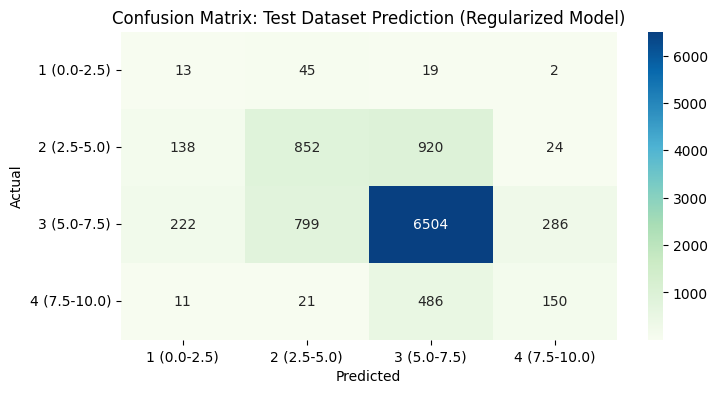

In [ ]:
# compute the confusion matrix
logreg_r_hyptun_test_cm = confusion_matrix(y_true=imdb_y_test, y_pred=logreg_r_hyptun_y_test_pred)

print_cm(logreg_r_hyptun_test_cm, 'Test Dataset Prediction (Regularized Model)')

As seen from the above models, the multiclass logistic regression with the best prediction accuracy is the one with L2 (Ridge) regularization. This accuracy improves significantly especially with our test dataset as the regularization generalizes our model to prevent overfitting on the train dataset.

## 7.3 Performance Overview
The accuracy of multiclass logistic regression in predicting these movie classifications is much improved from our previous FNN and decision tree models. This may be attributed to a couple of reasons to the fact that there was L2 (Ridge) regularization implemented into our model, which imposes additional penalty on loss function to finetune the bias-variance tradeoff. Given this, our model can be generalized so as to not overfit the train dataset and to improve prediction accuracy on test dataset.



# 8. Challenges/Limitations


---



From the raw dataset and preprocessing of dataset we noticed that:
* One, we had to impute the data on ` budget ` column to 0 for movies that might be too small or just do no release budget information.
* In addition, we one-hot encoded `production_country`, `production_company`, `director`, `star` by aggregating them first into top tiers and one-hot encode their ranking (determined by count of relevant movies) rather than one-hot encoding every single one individually.
* The remaining size of the dataset might be too small after 80/20 split between training and testing set, especially for FNN which could perform better had our dataset be bigger.

Other than limitations, a challenge that we had encountered during model training is addressing the biases. As we were training our models, we see a drop in accuracy after addressing for biases in our result. Therefore, as we tuned our hyperparameters, we had to keep in mind the balance between retaining high accuracy and addressing issues such as overfitting and class imbalances.

# 9. Next Steps


---



Next steps for this project can take a few different forms: the models that we introduce here could be made more robust; new models could be trained, providing new insights into this problem; and more dimensions to this problem could be explored.

**Improving these models:**
- Collecting more data to train these models on: as mentioned in limitations, our models were limited by the relatively low amount of data that we had to train on. If there was more data, these models would likely be much more accurate and reliable.
- Although we performed hyperparameter searches for all three of the models that we trained, there are always other options for model architectures, loss functions, etc. Those could be investigated and implemented, which may improve the performance of these models.

**New models:**
- Regression models can provide more granular predictions for ratings, which may or may not be necessary depending on the use case of these models.  Depending on whether PCA is done, and how correlation between features are handled, coefficients in the trained regression models can provide insights into the relative importance of different features. For example, regressions could help answer the question of whether the budget or the sentiment of the movie overview is more relevant for predicting ratings.

**Other facets of the problem:**
- Other features of the data could be explored in more depth, such as the "stars" of a movie, or who the director was. These could be one-hot encoded, or categorized in some other way using supplemental data on people involved in the film industry.
- Other movie databases such as TMDB could be explored, in addition to IMDB.
- Here, we predicted ratings of movies, but another thing that could be predicted to great relevant effect would be the revenue of movies - this can help with box office planning. Similar models to the ones we presented above could be used for this.

Overall, the models we have trained, tested, and presented in this project show that it is possible to predict movie ratings with relatively high accuracy, at least by using logistic regression. These could be very useful for recommending or ranking movies that do not have enough user ratings to reliably use the known ratings, or for other ratings-based classification.

